### Master’s Thesis
# Forecasting the volatility of financial time series using neural networks

#### Artem Koltsa


In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# import seaborn as sb

import datetime
import seaborn as sns
import numpy as np
import pandas as pd # https://pythononline.ru/osnovy/python-pandas
import yfinance as yf
import mplfinance as mpf # https://medium.com/mlearning-ai/stock-market-data-visualization-using-mplfinance-1d35a8d48e4
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras import models
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Input, Embedding, Bidirectional, Flatten, Dropout, Dense, BatchNormalization, RepeatVector, TimeDistributed
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model, model_to_dot
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping


import sys
sys.path.append('attentionmechanisms')  # add parent directory to Python path for layers.py access
from layers import Attention, SelfAttention

import sys
sys.path.append('attention-lzfelix')  # add parent directory to Python path for layers.py access
from layers_attention_lzfelix import AttentionLayer

import keras
print("Keras:", keras.__version__)

import tensorflow as tf
print("Tensorflow:", tf.__version__)

Keras: 2.4.3
Tensorflow: 2.4.1


### RV (realized volatility-variance )

#### - the realized volatility is here defined as the log of the square root of the realized variance

#### - реализованная волатильность здесь определяется как логарифм квадратного корня реализованной дисперсии

https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC

In [3]:
from datetime import datetime
# start_date = datetime(2020,8,24)
# end_date = datetime(2021,3,10)

gspc = yf.Ticker("^GSPC")
stock_data = gspc.history(period="max", actions=False)
stock_data

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2021-05-17,4169.919922,4171.919922,4142.689941,4163.290039,3307130000
2021-05-18,4165.939941,4169.149902,4125.990234,4127.830078,3559790000
2021-05-19,4098.450195,4116.930176,4061.409912,4115.680176,3485550000


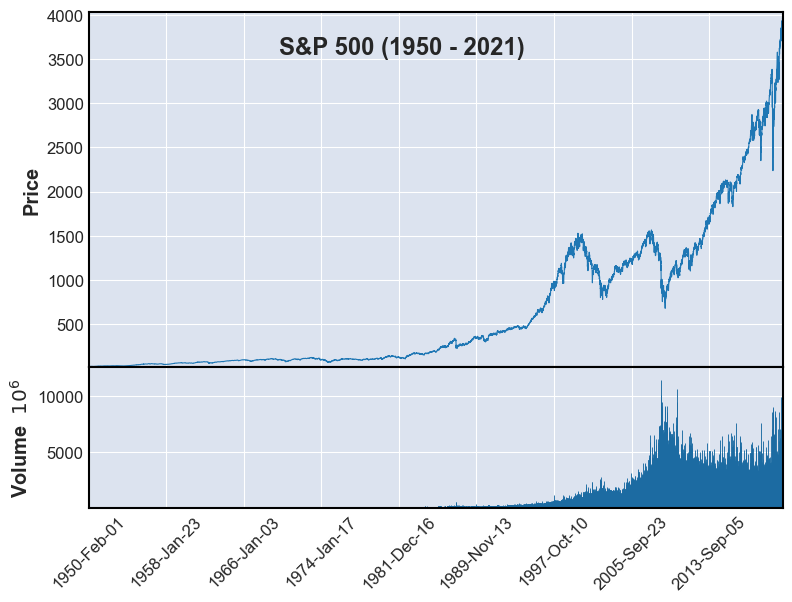

In [4]:
"""
Trading volume is a measure of how much of a given financial asset has traded in a period of time.
Trading volume is also a very important factor in understanding the price action and making trading/investment decisions. 
Trading volume provides insights on buying and selling pressure on the price.
Trading volume can be added to the chart by setting volume as True.

Объем торгов - это показатель того, сколько данного финансового актива было продано за определенный период времени.
Объем торгов также является очень важным фактором в понимании ценового действия и принятии торговых/инвестиционных решений. 
Объем торгов дает представление о давлении покупки и продажи на цену.
Торговый объем можно добавить на график, установив значение volume как True.

savefig='img.png' 
"""


mpf.plot(stock_data['1950-02':'2021-03'], type='line', title = 'S&P 500 (1950 - 2021)', 
         tight_layout=True, volume=True)

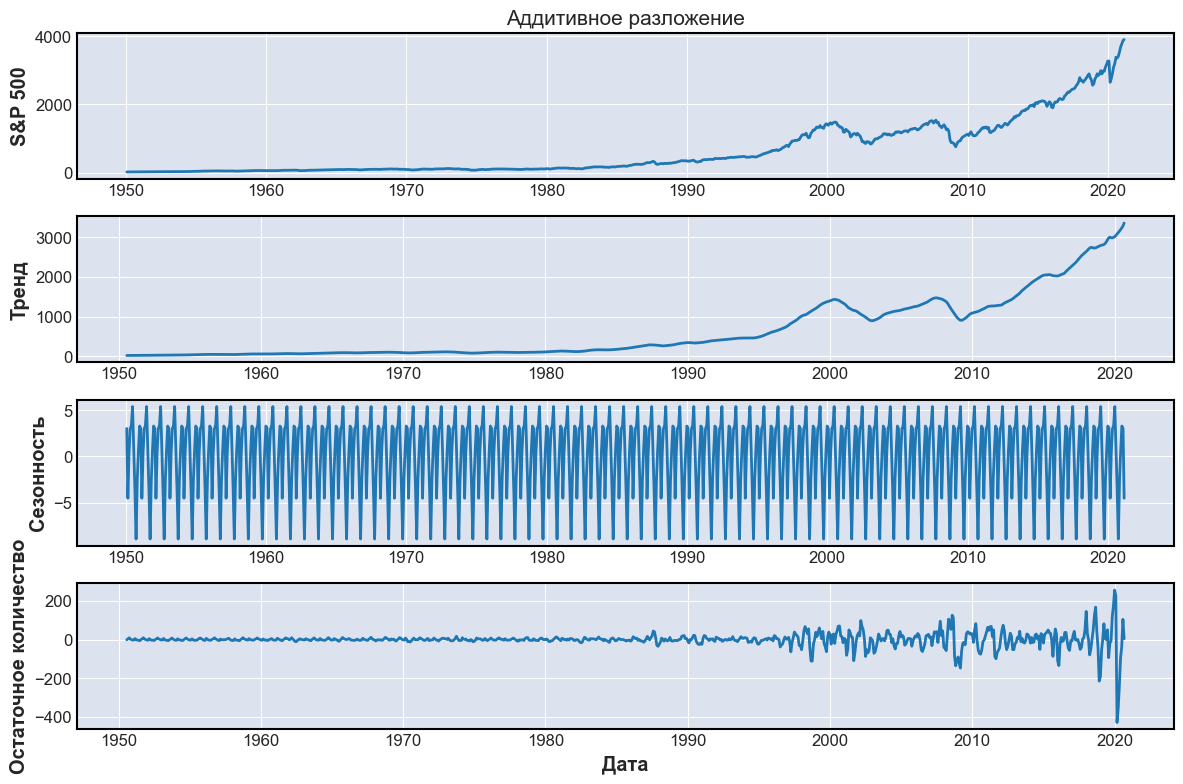

In [5]:
# https://www.machinelearningmastery.ru/decompose-time-series-data-trend-seasonality/

import statsmodels.api as sm
from pylab import rcParams
# rcParams['figure.figsize'] = 11, 8

y = stock_data['Close'].resample('MS').mean() # 'MS' на начало месяца
decomposition_additive = sm.tsa.seasonal_decompose(y['1950-02':'2021-03'], model='additive')

trend = decomposition_additive.trend
seasonal = decomposition_additive.seasonal
residual = decomposition_additive.resid

# Plot gathered statistics

fig = plt.figure(figsize=(12,8))

plt.subplot(411)
plt.title('Аддитивное разложение', fontsize = 15)
plt.ylabel('S&P 500')
plt.plot(y['1950-02':'2021-03'])
# plt.legend(loc='best')

plt.subplot(412)
plt.ylabel('Тренд')
plt.plot(trend, label='Trend')
# plt.legend(loc='best')

plt.subplot(413)
plt.ylabel('Сезонность')
plt.plot(seasonal,label='Seasonality')
# plt.legend(loc='best')

plt.subplot(414)
plt.ylabel('Остаточное количество')
plt.xlabel('Дата')
plt.plot(residual)
# plt.legend(loc='best')
plt.tight_layout()

# fig.savefig('additive_decomposition.jpg')
# decomposition.plot()
# pyplot.show()

In [6]:
from statsmodels.tsa.stattools import adfuller
residual.dropna(inplace=True)
print("Observations of Dickey-fuller test")
dftest = adfuller(residual,autolag='AIC')
dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in dftest[4].items():
    dfoutput['critical value (%s)'%key]= value
print(dfoutput)

# from stationarity_check_funtion import *
# residual.dropna(inplace=True)
# stationarity_check(residual)

Observations of Dickey-fuller test
Test Statistic                -8.381491e+00
p-value                        2.503105e-13
#lags used                     1.400000e+01
number of observations used    8.270000e+02
critical value (1%)           -3.438282e+00
critical value (5%)           -2.865041e+00
critical value (10%)          -2.568634e+00
dtype: float64


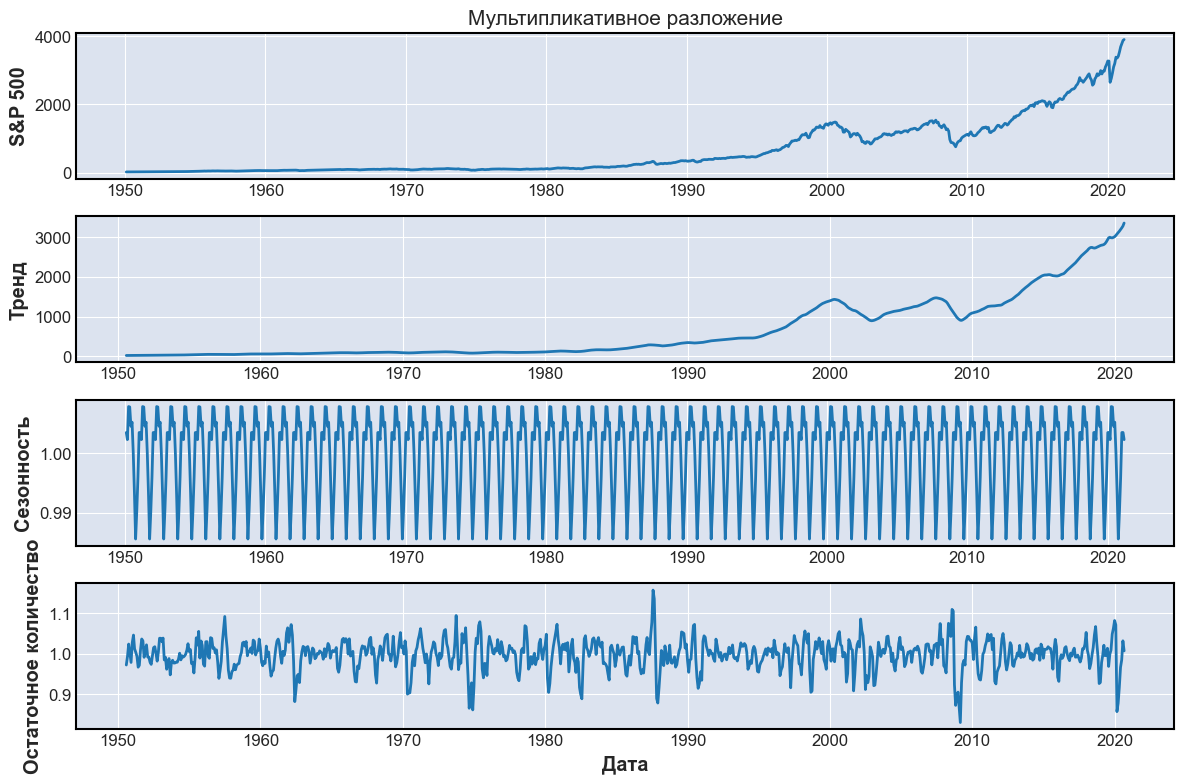

In [7]:
y = stock_data['Close'].resample('MS').mean() # 'MS' на начало месяца
decomposition_multiplicative = sm.tsa.seasonal_decompose(y['1950-02':'2021-03'], model='multiplicative')

trend = decomposition_multiplicative.trend
seasonal = decomposition_multiplicative.seasonal
residual = decomposition_multiplicative.resid

# Plot gathered statistics

fig = plt.figure(figsize=(12,8))

plt.subplot(411)
plt.title('Мультипликативное разложение', fontsize = 15)
plt.ylabel('S&P 500')
plt.plot(y['1950-02':'2021-03'])
# plt.legend(loc='best')

plt.subplot(412)
plt.ylabel('Тренд')
plt.plot(trend, label='Trend')
# plt.legend(loc='best')

plt.subplot(413)
plt.ylabel('Сезонность')
plt.plot(seasonal,label='Seasonality')
# plt.legend(loc='best')

plt.subplot(414)
plt.ylabel('Остаточное количество')
plt.xlabel('Дата')
plt.plot(residual)
# plt.legend(loc='best')
plt.tight_layout()

fig.savefig('multiplicative_decomposition.jpg')


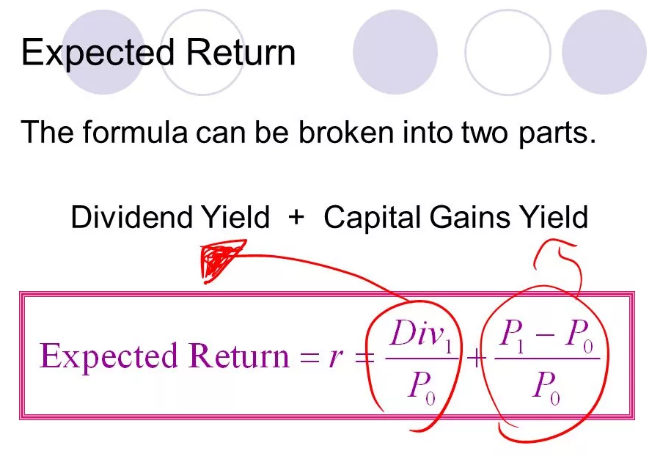

In [9]:
arr = stock_data['Close'].to_numpy()
simple_return = np.diff(arr) / arr[:-1] # p1 - p0 / p0
simple_return = np.insert(simple_return, 0, 0)
stock_data['Return'] = simple_return
stock_data

,Open,High,Low,Close,Volume,Return
Date,,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0,0.000000
1928-01-03,17.760000,17.760000,17.760000,17.760000,0,0.005663
1928-01-04,17.719999,17.719999,17.719999,17.719999,0,-0.002252
1928-01-05,17.549999,17.549999,17.549999,17.549999,0,-0.009594
1928-01-06,17.660000,17.660000,17.660000,17.660000,0,0.006268
...,...,...,...,...,...,...
2021-05-17,4169.919922,4171.919922,4142.689941,4163.290039,3307130000,-0.002530
2021-05-18,4165.939941,4169.149902,4125.990234,4127.830078,3559790000,-0.008517
2021-05-19,4098.450195,4116.930176,4061.409912,4115.680176,3485550000,-0.002943


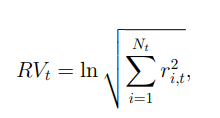

Набор данных, использованных в этом исследовании, включает ежемесячные наблюдения с февраля 1950 года по декабрь 2017 года в общей сложности 815 наблюдений. 

Реализованная дисперсия за месяц t вычисляется как сумма квадратов ежедневной доходности. Где r i,t ежедневная непрерывно составленная доходность в месяце t, Nt - количество торговых дней в течение месяца t. Реализация волатильности в статье определяется как логарифм квадратного корня реализованной дисперсии.

In [10]:
# метод скользящего окна!
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [11]:
stock_data_return = stock_data['Return']
stock_data_return = pd.DataFrame(stock_data_return)

# возводим в квадрат
stock_data_return_2 = np.square(stock_data_return)
# суммируем
stock_data_return_2_sum = stock_data_return_2.resample('M').sum()

# логарифм квадратного корня 
stock_data_return_2_sum_sqrt_log = stock_data_return_2_sum.apply(lambda x:np.log(np.sqrt(x)))

# переименование "Return" - "RV"
stock_data_return_2_sum_sqrt_log.columns = ['RV']
df_RV = stock_data_return_2_sum_sqrt_log

# обрезка дат для графика
df_RV_obr = df_RV.query('Date > "1949-01"')
df_RV_obr

c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,RV
Date,
1949-01-31,-2.967377
1949-02-28,-3.205454
1949-03-31,-3.391276
1949-04-30,-3.811957
1949-05-31,-3.455335
...,...
2021-01-31,-3.088273
2021-02-28,-3.250723
2021-03-31,-3.001122


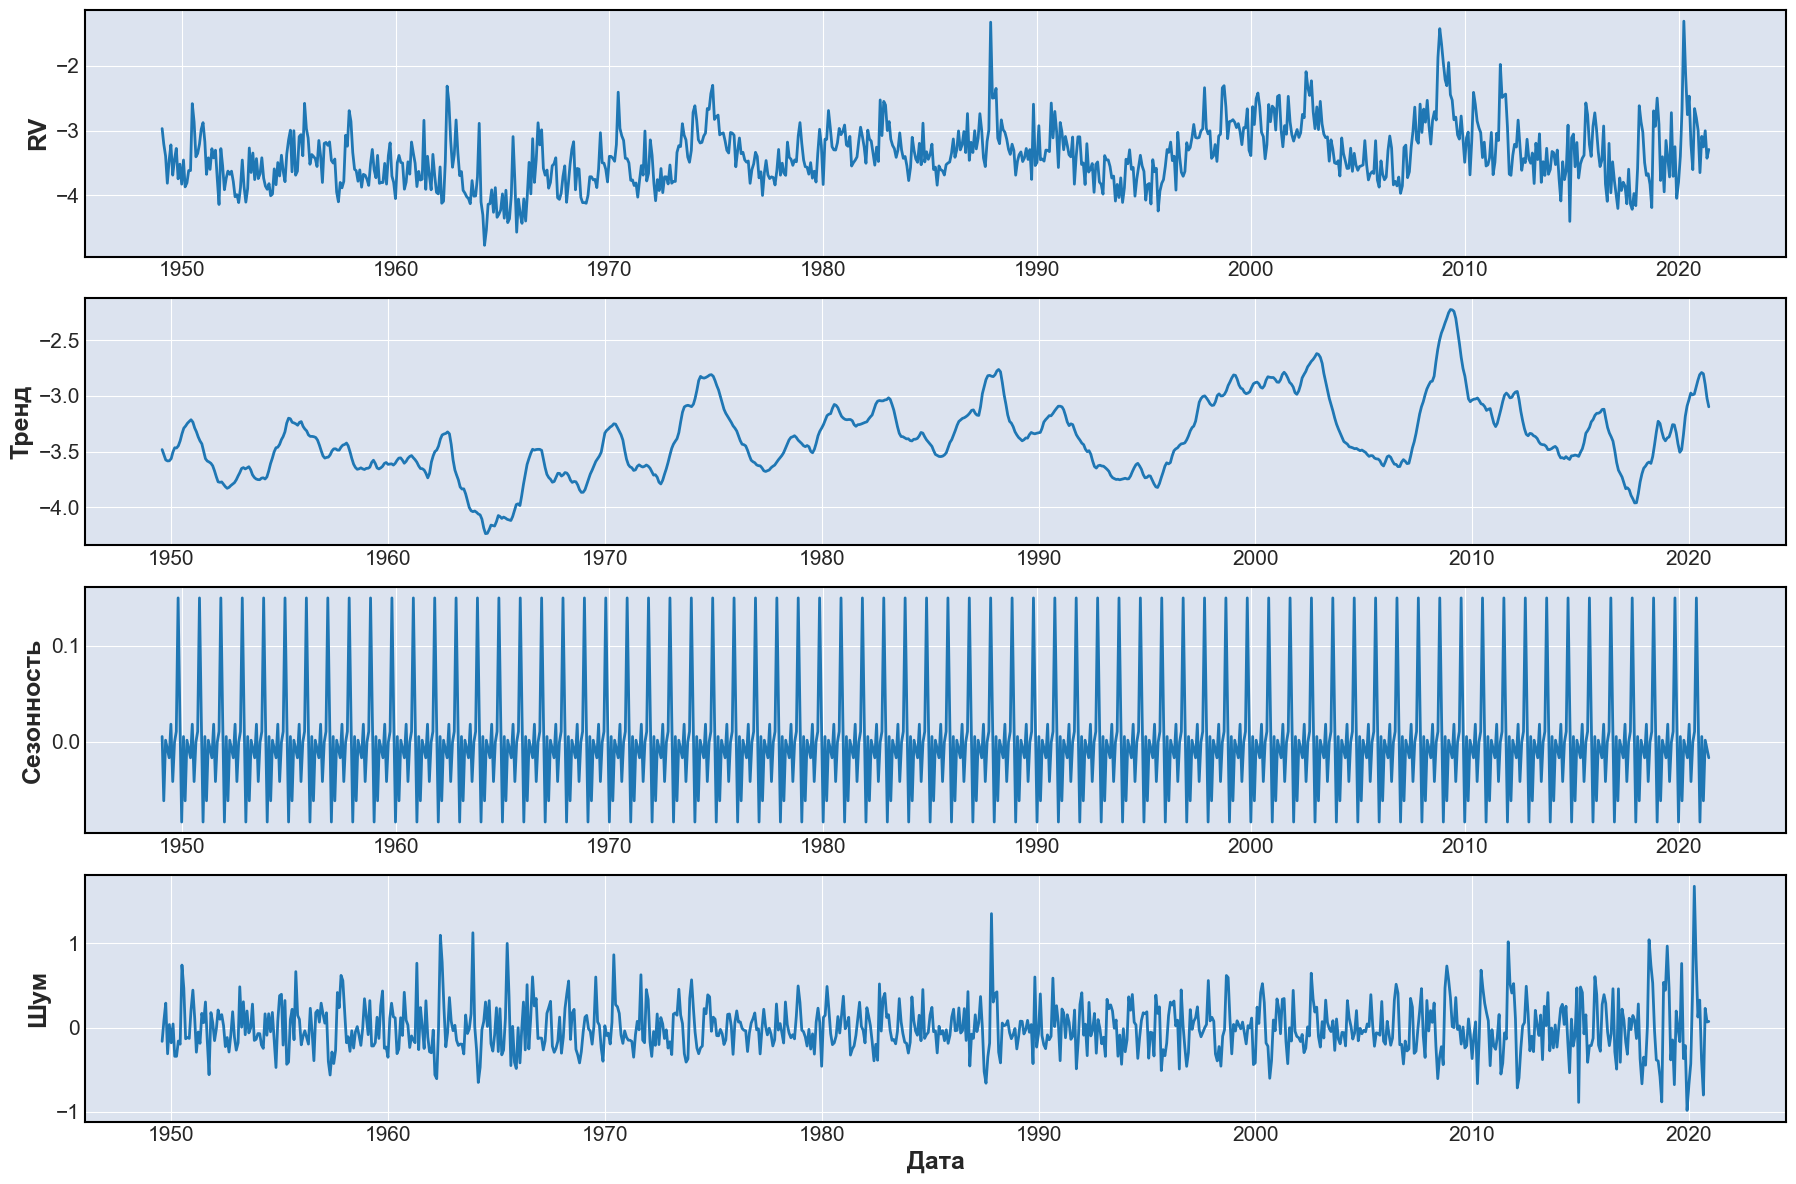

In [12]:
import statsmodels.api as sm
from pylab import rcParams
# rcParams['figure.figsize'] = 11, 8

# y = stock_data['Close'].resample('MS').mean() # 'MS' на начало месяца
decomposition_additive = sm.tsa.seasonal_decompose(df_RV_obr, model='additive')

trend = decomposition_additive.trend
seasonal = decomposition_additive.seasonal
residual = decomposition_additive.resid

# Plot gathered statistics

fig = plt.figure(figsize=(18,12))

plt.subplot(411)
# plt.title('Аддитивное разложение', fontsize = 15)
plt.ylabel('RV', fontweight='bold', fontsize=18)
plt.plot(df_RV_obr)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.legend(loc='best')

plt.subplot(412)
plt.ylabel('Тренд', fontweight='bold', fontsize=18)
plt.plot(trend, label='Trend')
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.legend(loc='best')

plt.subplot(413)
plt.ylabel('Сезонность', fontweight='bold', fontsize=18)
plt.plot(seasonal,label='Seasonality')
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.legend(loc='best')

plt.subplot(414)
plt.ylabel('Шум', fontweight='bold', fontsize=18)
plt.xlabel('Дата', fontweight='bold', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.plot(residual)
# plt.legend(loc='best')
plt.tight_layout()

fig.savefig('additive_decomposition.jpg')

# MSE
# MAE
# RMSE

Регрессия
Mean Absolute Error (MAE)
Метрика измеряет среднюю сумму абсолютной разницы между фактическим значением и прогнозируемым значением.



Mean Squared Error (MSE)
Измеряет среднюю сумму квадратной разности между фактическим значением и прогнозируемым значением для всех точек данных. Выполняется возведение во вторую степень, поэтому отрицательные значения не компенсируют положительными. А также в силу свойств этой метрики, усиливается влияние ошибок, по квадратуре от исходного значения. Это значит, что если в в исходных измерениях мы ошиблись на 1, то метрика покажет 1, 2-4, 3-9 и так далее. Чем меньше MSE, тем точнее наше предсказание. Оптимум достигается в точке 0, то есть мы идеально предсказываем.

По сравнению с средней абсолютной ошибкой, MSE  имеет некоторые преимущества:
Она подчеркивает большие ошибки над меньших ошибках.
Является дифференцируемым, что позволяет более эффективно использовать для поиска минимальных или максимальных значений с помощью математических методов.





Root Mean Squared Error (RMSE)
Это корень от квадрата ошибки. Ее легко интерпретировать, поскольку он имеет те же единицы, что и исходные значения (в отличие от MSE). Также она оперирует меньшими величинами по абсолютному значению, что может быть полезно для вычисления на компьютере.

http://blog.datalytica.ru/2018/05/blog-post.html


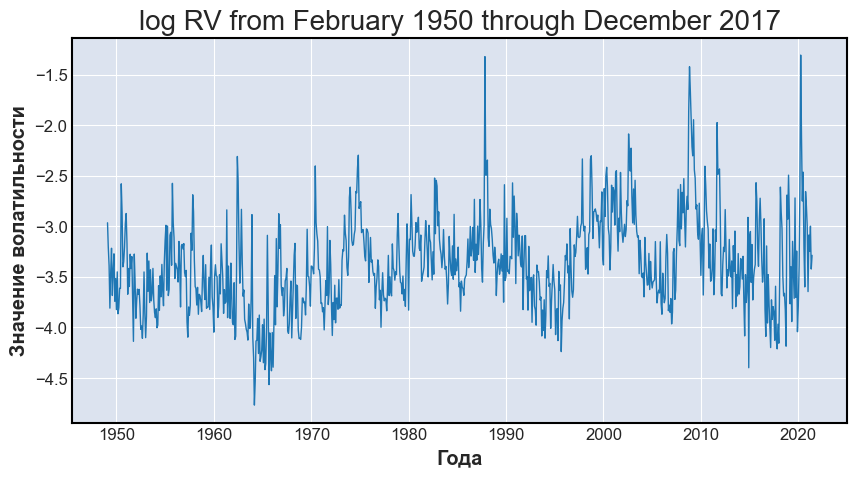

In [14]:
plt.figure(figsize=(10,5))
plt.xlabel('Года')
plt.ylabel('Значение волатильности')
plt.title('log RV from February 1950 through December 2017', fontsize = 20)
plt.plot(df_RV_obr.index, df_RV_obr.RV, linewidth = 1)

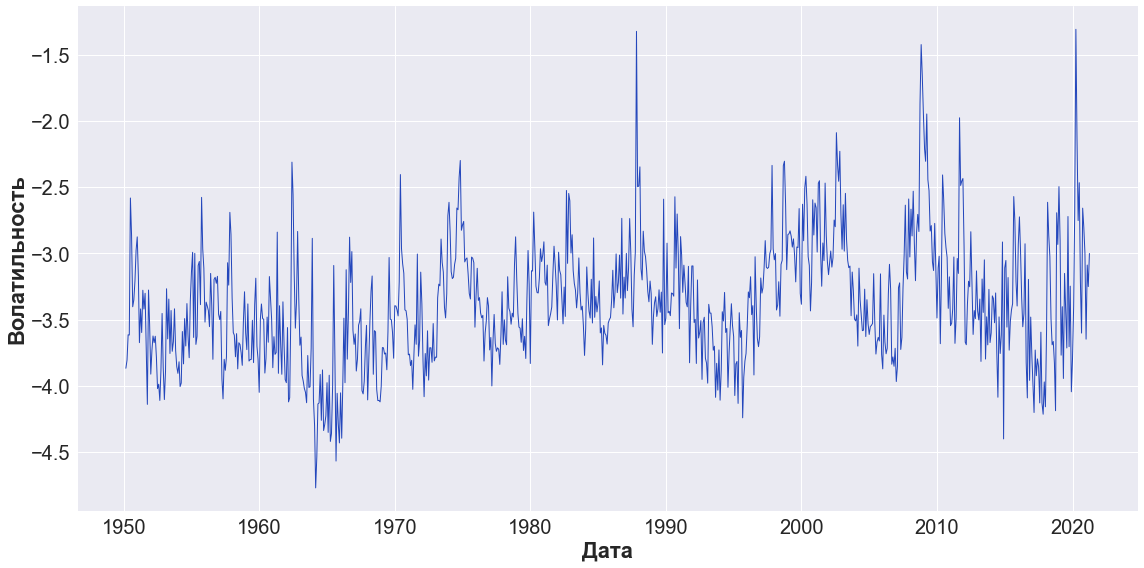

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot()
# ax.set(title = 'Основы анатомии matplotlib',
#        xlabel = 'ось абцис (XAxis)',
#        ylabel = 'ось ординат (YAxis)')
# Set tick font size
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
	label.set_fontsize(20)
plt.xlabel('Дата', fontsize=22, fontweight='bold')
plt.ylabel('Волатильность', fontsize=22, fontweight='bold')
ax.plot(df_RV_obr.RV['1950-02':'2021-03'], linewidth = 1, color='#2447bc')

plt.tight_layout()

plt.show()
fig.savefig('volatility_7.jpg')

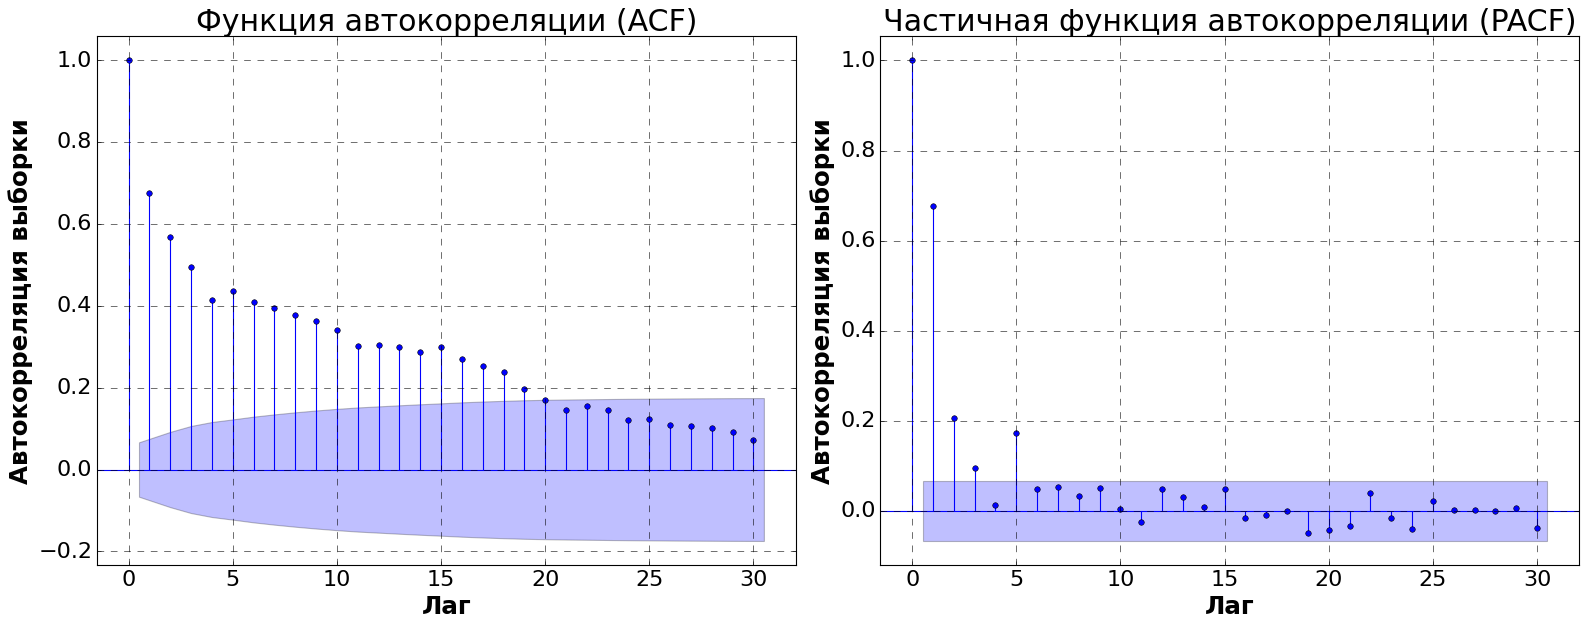

In [16]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from matplotlib import pyplot
pyplot.style.use('classic')

# https://medium.com/analytics-vidhya/interpreting-acf-or-auto-correlation-plot-d12e9051cd14
# https://github.com/bhattbhavesh91/time-series-decomposition-from-scratch/blob/master/time-series-decomposition-from-scratch.ipynb
# https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
# fig.patch.set_facecolor('blue')
fig.set(facecolor = 'white')
# fig.suptitle('Temperature', fontsize=50) # 

for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
	label.set_fontsize(20)
for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
	label.set_fontsize(20)
    
for label in (ax[1].get_title()):
	label.fontsize(50)
# for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
# 	label.set_fontsize(20)


# ax[1].get_title('TimeSSS Series')
    
ax[0].set_xlabel('Лаг', fontsize=22, fontweight='bold')
ax[0].set_ylabel('Автокорреляция выборки', fontsize=22, fontweight='bold')

ax[1].set_xlabel('Лаг', fontsize=22, fontweight='bold')
ax[1].set_ylabel('Автокорреляция выборки', fontsize=22, fontweight='bold')
# title = 'AAA'
# plt.title('log RV from February 1950 through December 2017', fontsize = 20)
# sm.graphics.tsa.plot_acf.title('Функция автокорреляции (ACF)')
sm.graphics.tsa.plot_acf(df_RV_obr.RV.values.squeeze(), lags=30, ax=ax[0])                       
sm.graphics.tsa.plot_pacf(df_RV_obr.RV.values.squeeze(), lags=30, ax=ax[1])

#сетка
ax[0].grid(axis = 'both', linestyle = '--')
ax[1].grid(axis = 'both', linestyle = '--')

ax[0].set_title('Функция автокорреляции (ACF)',fontsize= 27) # title of plot
ax[1].set_title('Частичная функция автокорреляции (PACF)',fontsize= 27) # title of plot

plt.tight_layout()
plt.show()
# ax.plot(plot_acf(df_RV_obr))
# ax2.set(plot_acf(df_RV_obr))
# plot_acf(df_RV_obr)
# plot_pacf(df_RV_obr, lags=30)
# plt.show()

fig.savefig('acf_pacf.jpg')

In [17]:
X = df_RV_obr.values
df_RV_t = timeseries_to_supervised(X, 3)
df_RV_t.columns = ['RV_t-1','RV_t-2','RV_t-3','RV_t']
df_RV_t['Date'] = df_RV_obr.index
df_RV_t

,RV_t-1,RV_t-2,RV_t-3,RV_t,Date
0,0.000000,0.000000,0.000000,-2.967377,1949-01-31
1,-2.967377,0.000000,0.000000,-3.205454,1949-02-28
2,-3.205454,-2.967377,0.000000,-3.391276,1949-03-31
3,-3.391276,-3.205454,-2.967377,-3.811957,1949-04-30
4,-3.811957,-3.391276,-3.205454,-3.455335,1949-05-31
...,...,...,...,...,...
864,-3.648049,-2.997329,-2.805091,-3.088273,2021-01-31
865,-3.088273,-3.648049,-2.997329,-3.250723,2021-02-28
866,-3.250723,-3.088273,-3.648049,-3.001122,2021-03-31
867,-3.001122,-3.250723,-3.088273,-3.425082,2021-04-30


In [18]:
df_RV_t = df_RV_t.query('Date < "2021-04" & Date > "1950-02"')
df_RV_t.reset_index(level=0, inplace=True)
df_RV_t.drop(['index','Date'], axis='columns', inplace=True)
df_RV_t

c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,RV_t-1,RV_t-2,RV_t-3,RV_t
0,-3.453331,-3.826444,-3.517811,-3.867848
1,-3.867848,-3.453331,-3.826444,-3.806102
2,-3.806102,-3.867848,-3.453331,-3.615268
3,-3.615268,-3.806102,-3.867848,-3.616940
4,-3.616940,-3.615268,-3.806102,-2.581866
...,...,...,...,...
849,-2.805091,-2.658501,-3.602143,-2.997329
850,-2.997329,-2.805091,-2.658501,-3.648049
851,-3.648049,-2.997329,-2.805091,-3.088273
852,-3.088273,-3.648049,-2.997329,-3.250723


In [19]:
df_RV_obr['1950-02':'2021-03']

,RV
Date,
1950-02-28,-3.867848
1950-03-31,-3.806102
1950-04-30,-3.615268
1950-05-31,-3.616940
1950-06-30,-2.581866
...,...
2020-11-30,-2.997329
2020-12-31,-3.648049
2021-01-31,-3.088273


# DP (Dividend Price Ratio) - отношение стоимости дивиденда к цене акции

##### Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices.

##### Коэффициент цены дивидендов (d/p) - это разница между логарифмом дивидендов и логарифмом цен.


https://www.multpl.com/s-p-500-dividend-yield/table/by-month

In [20]:
# загрузка DP обработка ограничителя ";" и перевод дробной части с запятой на точку
df_DP = pd.read_csv('DP.csv', delimiter=';', decimal=',')
df_DP['Date'] = pd.DatetimeIndex(df_DP.DateTime).normalize()
df_DP.set_index(df_DP['Date'], inplace=True)
df_DP.drop(['DateTime', 'Date'], axis='columns', inplace=True)
df_DP.columns = ['DP']
df_DP
X = df_DP.values
df_DP_t = timeseries_to_supervised(X, 1)
df_DP_t.columns = ['DP_t-1','DP_t']
df_DP_t['Date'] = df_DP.index
df_DP_t

df_DP_t = df_DP_t.query('Date < "2021-04" & Date > "1950-02"')
df_DP_t.reset_index(level=0, inplace=True)
df_DP_t.drop(['index','Date'], axis='columns', inplace=True)
df_DP_t


,DP_t-1,DP_t
0,6.81,6.74
1,6.74,6.74
2,6.74,6.61
3,6.61,6.45
4,6.45,6.40
...,...,...
849,1.72,1.65
850,1.65,1.58
851,1.58,1.53
852,1.53,1.49


In [21]:
df_DP['1950-02':'2021-03']

,DP
Date,
1950-02-28,6.74
1950-03-31,6.74
1950-04-30,6.61
1950-05-31,6.45
1950-06-30,6.40
...,...
2020-11-30,1.65
2020-12-30,1.58
2021-01-31,1.53


### Fama/French 3 Factors  MKT = (Mkt-Rf) + Rf

Market excess return Fama–French’s market factor: return of U.S. stock market minus one-month T-bill rate.

Рыночная избыточная доходность Fama-French market factor: доходность американского фондового рынка минус месячная ставка T-bill.

http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html

In [22]:
# формат даты парсить
dateparser = lambda x: pd.datetime.strptime(x, "%Y%m")
# загрузка Mkt-Rf обработка ограничителя ","
df_MKT = pd.read_csv("Mkt-Rf.csv", sep=',', parse_dates=['date'], date_parser=dateparser)

# MKT = (Mkt-RF) + RF
df_MKT['MKT'] = df_MKT[['Mkt-RF','RF']].sum(axis=1)

df_MKT.set_index(df_MKT['date'], inplace=True)
df_MKT.drop(columns=['date','Mkt-RF','SMB','HML', 'RF'], inplace=True)
df_MKT

X = df_MKT.values
df_MKT_t = timeseries_to_supervised(X, 1)
df_MKT_t.columns = ['MKT_t-1','MKT_t']
df_MKT_t['Date'] = df_MKT.index


# выбор дат с февраля 1950 по 2020 декабрь
df_MKT_t = df_MKT_t.query('Date < "2021-04" & Date > "1950-01"')

df_MKT_t.reset_index(level=0, inplace=True)
df_MKT_t.drop(['index','Date'], axis='columns', inplace=True)
df_MKT_t

c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,MKT_t-1,MKT_t
0,1.79,1.57
1,1.57,1.36
2,1.36,4.03
3,4.03,4.41
4,4.41,-5.84
...,...,...
849,-2.09,12.48
850,12.48,4.64
851,4.64,-0.03
852,-0.03,2.78


In [23]:
df_MKT['1950-02':'2021-03']

,MKT
date,
1950-02-01,1.57
1950-03-01,1.36
1950-04-01,4.03
1950-05-01,4.41
1950-06-01,-5.84
...,...
2020-11-01,12.48
2020-12-01,4.64
2021-01-01,-0.03


### STR
Short-term reversal factor Fama–French’s STR: average return on stocks with low prior return minus average return on stock with high prior return.

Краткосрочным фактором разворота Фама–френч ул. Средняя доходность акций с низким до возвращения средний минус доходность акций с высоким до возвращения.

http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/det_st_rev_factor.html

In [24]:
# формат даты парсить
dateparser = lambda x: pd.datetime.strptime(x, "%Y%m")
# загрузка Mkt-Rf обработка ограничителя ","
df_STR = pd.read_csv("STR.csv", sep=',', parse_dates=['date'], date_parser=dateparser)
df_STR.set_index(df_STR['date'], inplace=True)
df_STR.drop(columns=['date'], inplace=True)

X = df_STR.values
df_STR_t = timeseries_to_supervised(X, 1)
df_STR_t.columns = ['STR_t-1','STR_t']
df_STR_t['Date'] = df_STR.index


# выбор дат с февраля 1950 по 2021 март
df_STR_t = df_STR_t.query('Date < "2021-04" & Date > "1950-01"')
df_STR_t.reset_index(level=0, inplace=True)
df_STR_t.drop(['index','Date'], axis='columns', inplace=True)
df_STR_t

c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


,STR_t-1,STR_t
0,0.76,1.10
1,1.10,0.96
2,0.96,2.08
3,2.08,-1.00
4,-1.00,0.96
...,...,...
849,0.69,3.23
850,3.23,-3.08
851,-3.08,0.36
852,0.36,4.11


In [25]:
df_STR['1950-02':'2021-03']

,ST_Rev
date,
1950-02-01,1.10
1950-03-01,0.96
1950-04-01,2.08
1950-05-01,-1.00
1950-06-01,0.96
...,...
2020-11-01,3.23
2020-12-01,-3.08
2021-01-01,0.36


The default spread (DEF) completes the set of financial determinants to approximate credit risk.
Дефолтный спред (DEF) завершает набор финансовых детерминант для аппроксимации кредитного риска.

Measure of default risk of corporate bonds: difference of BAA and AAA bond yields.
Мера риска дефолта корпоративных облигаций: разница доходностей облигаций BAA и AAA.

https://fred.stlouisfed.org/graph/?g=f09

In [26]:
df_AAA_BAA = pd.read_csv('BAA_AAA.csv', sep=',')
df_AAA_BAA.set_index(df_AAA_BAA['DATE'], inplace=True)
df_AAA_BAA.drop(columns='DATE', inplace=True)

df_AAA_BAA

X = df_AAA_BAA.values
df_AAA_BAA_t = timeseries_to_supervised(X, 1)
df_AAA_BAA_t.columns = ['DEF_t-1','DEF_t']
df_AAA_BAA_t['Date'] = df_AAA_BAA.index

df_AAA_BAA_t


# # выбор дат с февраля 1950 по 2021 март
df_AAA_BAA_t = df_AAA_BAA_t.query('Date < "2021-04" & Date > "1950-02"')
df_AAA_BAA_t.reset_index(level=0, inplace=True)
df_AAA_BAA_t.drop(['index','Date'], axis='columns', inplace=True)
df_AAA_BAA_t

,DEF_t-1,DEF_t
0,0.67,0.66
1,0.66,0.66
2,0.66,0.63
3,0.63,0.64
4,0.64,0.66
...,...,...
849,1.09,1.00
850,1.00,0.90
851,0.90,0.79
852,0.79,0.72


In [27]:
df_AAA_BAA['1950-02':'2021-04']

,BAA_AAA
DATE,
1950-02-01,0.66
1950-03-01,0.66
1950-04-01,0.63
1950-05-01,0.64
1950-06-01,0.66
...,...
2020-11-01,1.00
2020-12-01,0.90
2021-01-01,0.79


In [28]:
# Monthly inflation rate for the US area
# https://www.statbureau.org/en/united-states/inflation-tables
# Объяснение что это за признак
# https://inflationdata.com/articles/charts/annual-inflation

infl_us = pd.read_csv('PredictorData2020.csv', sep=';', parse_dates=['yyyymm'], 
    date_parser=lambda x: pd.to_datetime(x, format="%Y%m"), index_col="yyyymm")

infl_us = infl_us[['infl', 'infl-new100', 'infl-new1000']]

X = infl_us['infl-new100'].values
infl_us_t = timeseries_to_supervised(X, 1)
infl_us_t.columns = ['infl_t-1','infl_t']
infl_us_t['Date'] = infl_us.index

infl_us_t

infl_us_t = infl_us_t.query('Date > "1950-01"')
infl_us_t.reset_index(level=0, inplace=True)
infl_us_t.drop(['index','Date'], axis='columns', inplace=True)
infl_us_t


,infl_t-1,infl_t
0,"-0,423729",0
1,0,"0,425532"
2,"0,425532",0
3,0,"0,423729"
4,"0,423729","0,421941"
...,...,...
849,"0,041494","-0,061063"
850,"-0,061063","0,094148"
851,"0,094148","0,430000"
852,"0,430000","0,550000"


In [29]:
X = infl_us['infl-new100'].values
infl_us_t1 = timeseries_to_supervised(X, 1)
infl_us_t1.columns = ['infl_t-1','infl_t']
infl_us_t1['Date'] = infl_us.index

infl_us_t1

infl_us_t1 = infl_us_t1.query('Date > "1950-01"')

infl_us_t1

,infl_t-1,infl_t,Date
949,"-0,423729",0,1950-02-01
950,0,"0,425532",1950-03-01
951,"0,425532",0,1950-04-01
952,0,"0,423729",1950-05-01
953,"0,423729","0,421941",1950-06-01
...,...,...,...
1798,"0,041494","-0,061063",2020-11-01
1799,"-0,061063","0,094148",2020-12-01
1800,"0,094148","0,430000",2021-01-01
1801,"0,430000","0,550000",2021-02-01


In [30]:
# Monthly Fed funds rates
# Effective Federal Funds Rate (FEDFUNDS)
# https://fred.stlouisfed.org/series/FEDFUNDS
# https://www.investopedia.com/terms/f/federalfundsrate.asp
# dayli file:///C:/Users/artemkoltsa/Downloads/feds2020059/accessible_figures.html
fedfunds = pd.read_csv('FEDFUNDS.csv', sep=';', parse_dates=['observation_date'], 
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m"), index_col="observation_date")

X = fedfunds.values
fedfunds_t = timeseries_to_supervised(X, 1)
fedfunds_t.columns = ['fedfunds_t-1','fedfunds_t']
fedfunds_t['Date'] = fedfunds.index

# fedfunds = fedfunds.query('observation_date > "1950-01"')
fedfunds_t

# # выбор дат с февраля 1950 по 2021 март
fedfunds_t = fedfunds_t.query('Date < "2021-04" & Date > "1950-01"')
fedfunds_t.reset_index(level=0, inplace=True)
fedfunds_t.drop(['index','Date'], axis='columns', inplace=True)
fedfunds_t

,fedfunds_t-1,fedfunds_t
0,"0,52","1,22"
1,"1,22","1,03"
2,"1,03","1,31"
3,"1,31","0,88"
4,"0,88","0,65"
...,...,...
849,"0,09","0,09"
850,"0,09","0,09"
851,"0,09","0,09"
852,"0,09","0,08"


In [31]:
fedfunds['1950-02':'2021-04']

,FEDFUNDS
observation_date,
1950-02-01,"1,22"
1950-03-01,"1,03"
1950-04-01,"1,31"
1950-05-01,"0,88"
1950-06-01,"0,65"
...,...
2020-11-01,"0,09"
2020-12-01,"0,09"
2021-01-01,"0,09"


In [34]:
# Chicago Fed National Activity Index (CFNAI)
# https://fred.stlouisfed.org/series/CFNAI

CFNAI = pd.read_csv('CFNAI.csv', sep=',', parse_dates=['DATE'], 
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m"), index_col="DATE")

# https://issue.life/questions/13784192
# todays_date = datetime.datetime.now().date() сегодняшняя дата

# создание пустого датафрейма с 1950-02-01 на 205 строк
index = pd.date_range(datetime.date(1950, 2, 1), periods=205, freq='M')
columns = ['CFNAI']
df_0 = pd.DataFrame(index=index, columns=columns)
df_0 = df_0.fillna(0) # with 0s rather than NaNs
df_0

newCFNAI = df_0.append(CFNAI) # ignoring index is optional
newCFNAI

X = newCFNAI.values
newCFNAI_t = timeseries_to_supervised(X, 1)
newCFNAI_t.columns = ['cfnai_t-1','cfnai_t']
newCFNAI_t['Date'] = newCFNAI.index

newCFNAI_t

# # выбор дат с февраля 1950 по 2021 март
newCFNAI_t = newCFNAI_t.query('Date < "2021-04" & Date > "1950-01"')
newCFNAI_t.reset_index(level=0, inplace=True)
newCFNAI_t.drop(['index','Date'], axis='columns', inplace=True)
newCFNAI_t

,cfnai_t-1,cfnai_t
0,0.00,0.00
1,0.00,0.00
2,0.00,0.00
3,0.00,0.00
4,0.00,0.00
...,...,...
849,1.01,0.36
850,0.36,0.32
851,0.32,1.10
852,1.10,-1.20


In [35]:
newCFNAI['1950-02':'2021-04']

,CFNAI
1950-02-28,0.00
1950-03-31,0.00
1950-04-30,0.00
1950-05-31,0.00
1950-06-30,0.00
...,...
2020-11-01,0.36
2020-12-01,0.32
2021-01-01,1.10
2021-02-01,-1.20


In [36]:
# создание колонки Date
index_all = pd.DataFrame(infl_us_t1['Date'])
index_all.reset_index(inplace = True)
index_all.drop(['index'], axis='columns', inplace=True)
index_all

,Date
0,1950-02-01
1,1950-03-01
2,1950-04-01
3,1950-05-01
4,1950-06-01
...,...
849,2020-11-01
850,2020-12-01
851,2021-01-01
852,2021-02-01


# Сохранение датасета "df_all_features"

In [ ]:
df_all_features = pd.concat([index_all, df_RV_t, df_DP_t, df_MKT_t, df_STR_t, df_AAA_BAA_t, infl_us_t, fedfunds_t, newCFNAI_t], axis=1)
df_all_features['infl_t-1'] = [float(str(i).replace(",", ".")) for i in df_all_features['infl_t-1']]
df_all_features['infl_t'] = [float(str(i).replace(",", ".")) for i in df_all_features['infl_t']]
df_all_features['fedfunds_t-1'] = [float(str(i).replace(",", ".")) for i in df_all_features['fedfunds_t-1']]
df_all_features['fedfunds_t'] = [float(str(i).replace(",", ".")) for i in df_all_features['fedfunds_t']]


# сохранение готового датасета!!!
df_all_features.to_csv('df_all_features.csv', index=False)
df_all_features.info()

# Загрузка датасета "df_all_features"

In [38]:
df_all_f = pd.read_csv('df_all_features.csv', parse_dates=['Date'], 
    date_parser=lambda x: pd.to_datetime(x, format="%Y-%m"))
# print(df_all_f)
# from February 1950 to March 2021 for a total of 854 observations
X_RV = df_all_f[['RV_t-1','RV_t-2','RV_t-3','RV_t']]

X_RV_art_b = df_all_f[['RV_t-1','RV_t-2','RV_t-3','MKT_t-1','STR_t-1','RV_t']]

X_RV_art_a = df_all_f[['RV_t-1','RV_t-2','RV_t-3','DP_t-1','MKT_t-1','STR_t-1','DEF_t-1','RV_t']]

X_RV_all = df_all_f[['RV_t-1','RV_t-2','RV_t-3','DP_t-1','MKT_t-1','STR_t-1','DEF_t-1','infl_t-1','fedfunds_t-1','cfnai_t-1','RV_t']]

X_RV_xgb = df_all_f[['RV_t-1','RV_t-2','RV_t-3','MKT_t-1','DEF_t-1','fedfunds_t-1','RV_t']]

y_RV = df_all_f[['RV_t']]

y_RV

,RV_t
0,-3.867848
1,-3.806102
2,-3.615268
3,-3.616940
4,-2.581866
...,...
849,-2.997329
850,-3.648049
851,-3.088273
852,-3.250723


In [39]:
df_all_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          854 non-null    datetime64[ns]
 1   RV_t-1        854 non-null    float64       
 2   RV_t-2        854 non-null    float64       
 3   RV_t-3        854 non-null    float64       
 4   RV_t          854 non-null    float64       
 5   DP_t-1        854 non-null    float64       
 6   DP_t          854 non-null    float64       
 7   MKT_t-1       854 non-null    float64       
 8   MKT_t         854 non-null    float64       
 9   STR_t-1       854 non-null    float64       
 10  STR_t         854 non-null    float64       
 11  DEF_t-1       854 non-null    float64       
 12  DEF_t         854 non-null    float64       
 13  infl_t-1      854 non-null    float64       
 14  infl_t        854 non-null    float64       
 15  fedfunds_t-1  854 non-null    float64   

In [40]:
# преобразование в массив (array) # 563
values = X_RV_xgb.values
# split into train and test sets
train = values[:574, :]
test = values[574:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
samples_train_X = train_X.shape[0]
samples_test_X = test_X.shape[0]
timesteps = 1
features_train_X = train_X.shape[1]
features_test_X = test_X.shape[1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(574, 1, 6) (574,) (280, 1, 6) (280,)


In [41]:
from sklearn.metrics import mean_absolute_error
# hyperparameters

patience = 30
epochs = 100
units_lstm = 50

def build_LSTM_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, name='lstm')(model_in)
    output   = Dense(units=1)(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_ATT_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, name='lstm', return_sequences=True)(model_in)
    descr    = AttentionLayer(name='attention')(vectors)
#     descr    = Attention1(name='attention')(vectors)
    output   = Dense(units=1)(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_Stacked_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, activation='relu', name='lstm_stacked_1', return_sequences=True)(model_in)
    vectors_1 = LSTM(units=units_lstm, activation='relu', name='lstm_stacked_2')(vectors)
    output   = Dense(units=1)(vectors_1)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_Stacked_ATT_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, activation='relu', name='lstm_stacked_1', return_sequences=True)(model_in)
    vectors_1 = LSTM(units=units_lstm, activation='relu', name='lstm_stacked_2', return_sequences=True)(vectors)
    descr    = AttentionLayer(name='attention')(vectors_1)
#     descr    = Attention1(name='attention')(vectors_1)
    output   = Dense(units=1)(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_Bidirectional_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = Bidirectional(LSTM(units=units_lstm, activation='relu', name='lstm_bidirectional_1'))(model_in)
    output   = Dense(units=1)(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_Bidirectional_ATT_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = Bidirectional(LSTM(units=units_lstm, activation='relu', name='lstm_bidirectional_1', return_sequences=True))(model_in)
    descr    = AttentionLayer(name='attention')(vectors)
#     descr    = Attention1(name='attention')(vectors)
    output   = Dense(units=1)(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_Vanilla_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, activation='relu', name='lstm_vanilla')(model_in)
    output   = Dense(units=1)(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_Vanilla_ATT_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, activation='relu', name='lstm_vanilla', return_sequences=True)(model_in)
    descr    = AttentionLayer(name='attention')(vectors)
#     descr    = Attention1(name='attention')(vectors)
    output   = Dense(units=1)(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                11400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


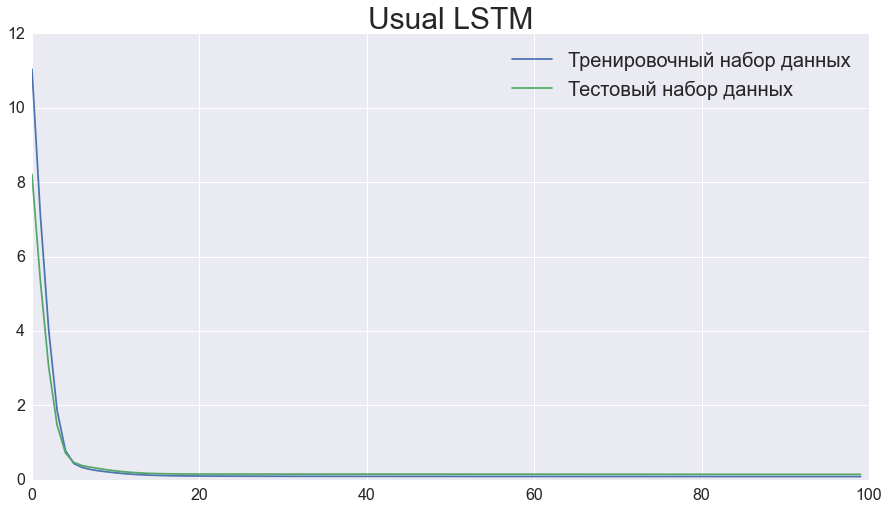

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.146
Test MAE: 0.282
Test RMSE: 0.382


evaluate the model
Train: 0.086, Test: 0.146


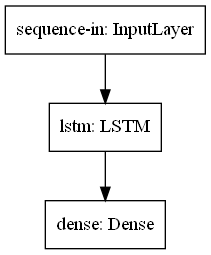

In [42]:
LSTM_model = build_LSTM_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_LSTM = LSTM_model.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('Usual LSTM', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_model.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_model.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

plot_model(LSTM_model, show_shapes=False, show_layer_names=True, to_file='LSTM_model.png')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 50)             11400     
_________________________________________________________________
attention (AttentionLayer)   (None, 50)                2600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 14,051
Trainable params: 14,051
Non-trainable params: 0
_________________________________________________________________


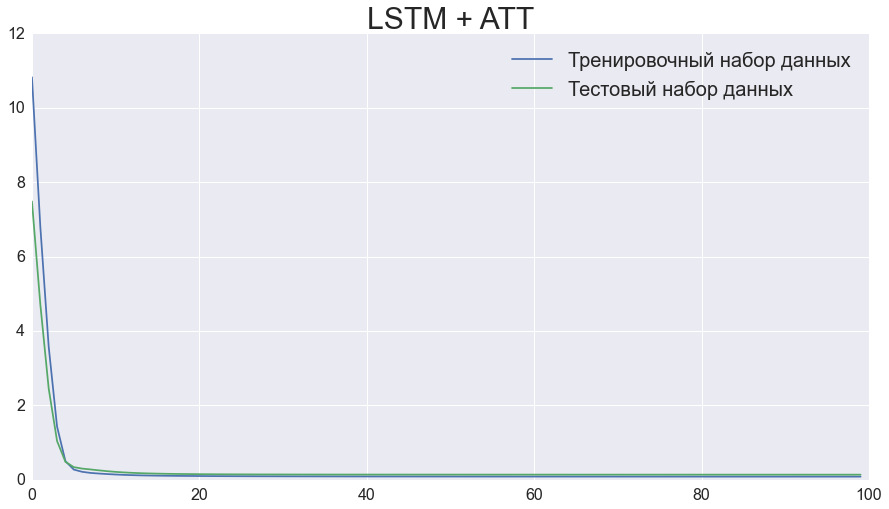

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.138
Test MAE: 0.275
Test RMSE: 0.372


evaluate the model
Train: 0.084, Test: 0.138


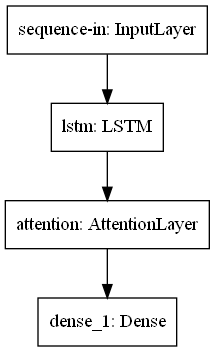

In [43]:
LSTM_ATT = build_LSTM_ATT_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_LSTM_ATT = LSTM_ATT.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM_ATT.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM_ATT.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM + ATT', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_ATT.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_ATT.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_ATT.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))


plot_model(LSTM_ATT, show_shapes=False, show_layer_names=True, to_file='LSTM_ATT.png')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
lstm_stacked_1 (LSTM)        (None, 1, 50)             11400     
_________________________________________________________________
lstm_stacked_2 (LSTM)        (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 31,651
Trainable params: 31,651
Non-trainable params: 0
_________________________________________________________________


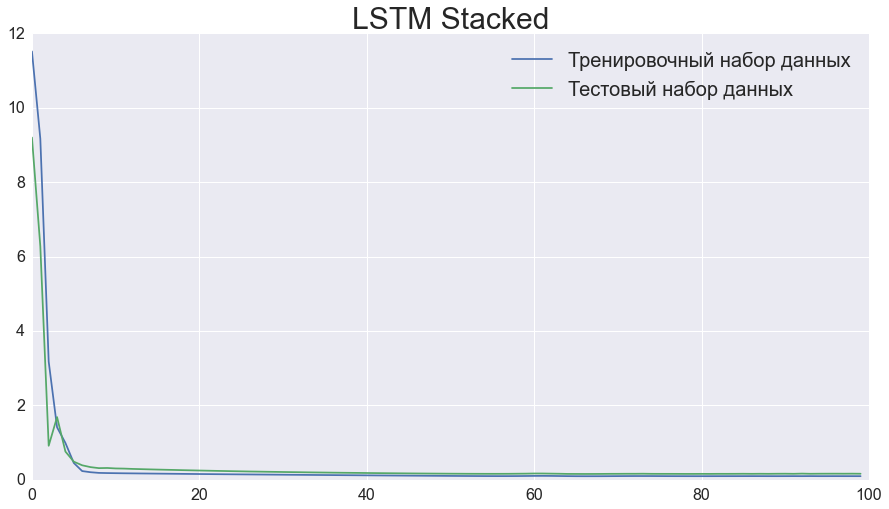

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.163
Test MAE: 0.294
Test RMSE: 0.404


evaluate the model
Train: 0.088, Test: 0.163


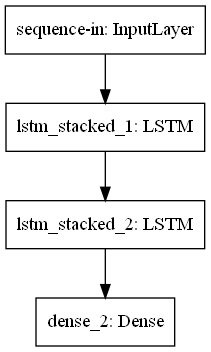

In [44]:
LSTM_Stacked_model = build_LSTM_Stacked_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_LSTM = LSTM_Stacked_model.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM Stacked', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_Stacked_model.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_Stacked_model.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_Stacked_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

plot_model(LSTM_Stacked_model, show_shapes=False, show_layer_names=True, to_file='LSTM_Stacked_model.png')

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
lstm_stacked_1 (LSTM)        (None, 1, 50)             11400     
_________________________________________________________________
lstm_stacked_2 (LSTM)        (None, 1, 50)             20200     
_________________________________________________________________
attention (AttentionLayer)   (None, 50)                2600      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 34,251
Trainable params: 34,251
Non-trainable params: 0
_________________________________________________________________


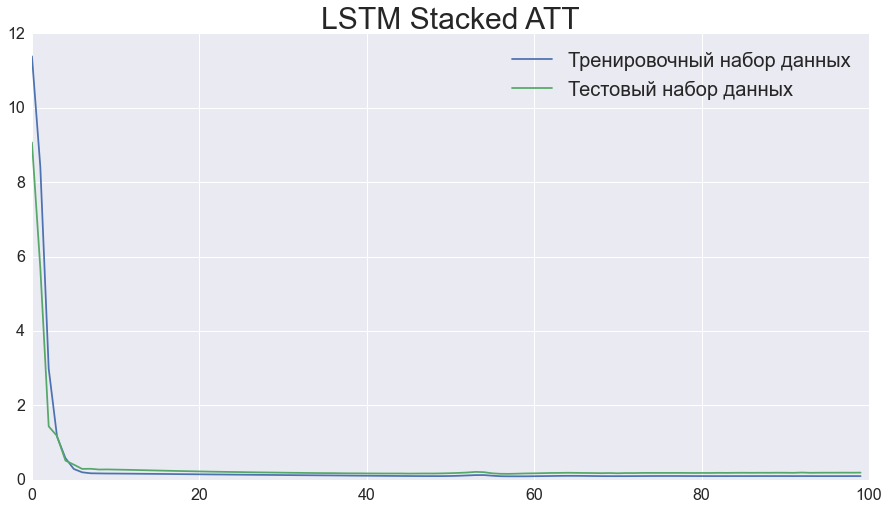

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.193
Test MAE: 0.311
Test RMSE: 0.440


evaluate the model
Train: 0.089, Test: 0.193


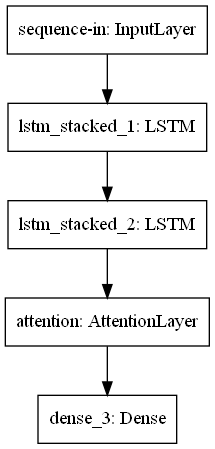

In [45]:
LSTM_Stacked_ATT_model = build_LSTM_Stacked_ATT_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_LSTM = LSTM_Stacked_ATT_model.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM Stacked ATT', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_Stacked_ATT_model.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_Stacked_ATT_model.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_Stacked_ATT_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

plot_model(LSTM_Stacked_ATT_model, show_shapes=False, show_layer_names=True, to_file='LSTM_Stacked_ATT_model.png')

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               22800     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 22,901
Trainable params: 22,901
Non-trainable params: 0
_________________________________________________________________


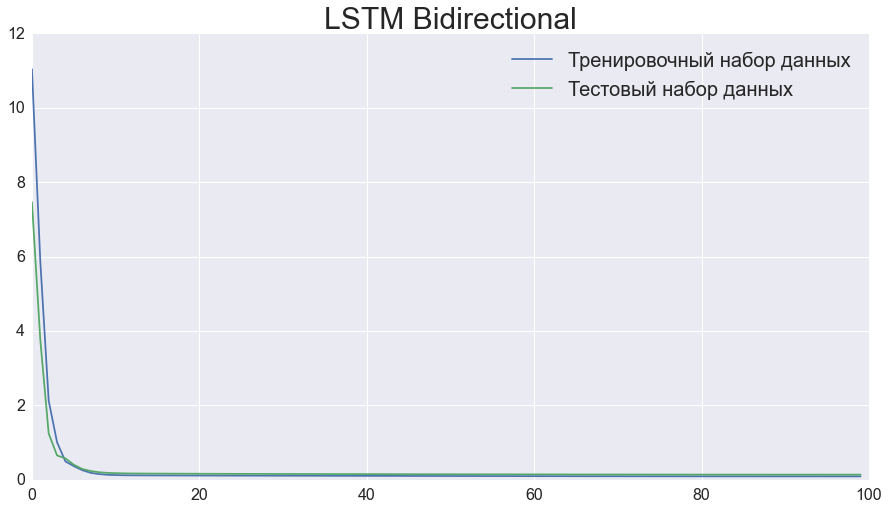

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.139
Test MAE: 0.272
Test RMSE: 0.373


evaluate the model
Train: 0.088, Test: 0.139


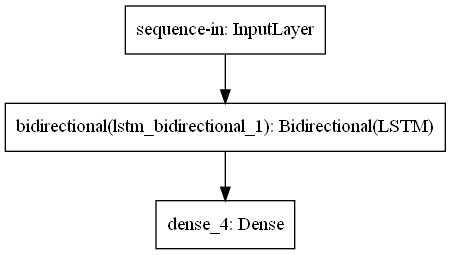

In [46]:
LSTM_Bidirectional_model = build_LSTM_Bidirectional_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_LSTM = LSTM_Bidirectional_model.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM Bidirectional', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_Bidirectional_model.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_Bidirectional_model.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_Bidirectional_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

plot_model(LSTM_Bidirectional_model, show_shapes=False, show_layer_names=True, to_file='LSTM_Bidirectional_model.png')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1, 100)            22800     
_________________________________________________________________
attention (AttentionLayer)   (None, 100)               10200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 33,101
Trainable params: 33,101
Non-trainable params: 0
_________________________________________________________________


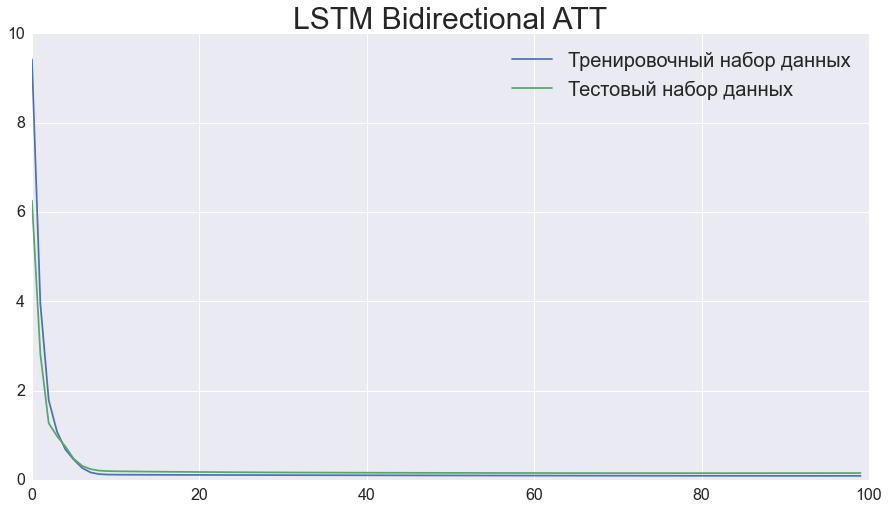

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.151
Test MAE: 0.285
Test RMSE: 0.389


evaluate the model
Train: 0.085, Test: 0.151


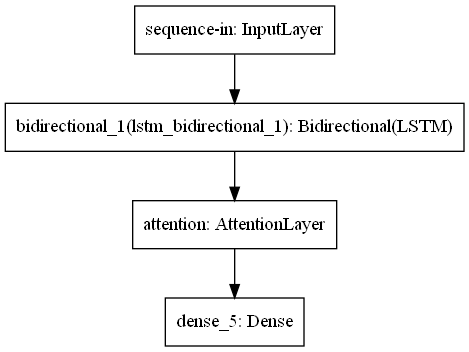

In [47]:
LSTM_Bidirectional_ATT_model = build_LSTM_Bidirectional_ATT_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_LSTM = LSTM_Bidirectional_ATT_model.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM Bidirectional ATT', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_Bidirectional_ATT_model.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_Bidirectional_ATT_model.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_Bidirectional_ATT_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

plot_model(LSTM_Bidirectional_ATT_model, show_shapes=False, show_layer_names=True, to_file='LSTM_Bidirectional_ATT_model.png')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
lstm_vanilla (LSTM)          (None, 50)                11400     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 11,451
Trainable params: 11,451
Non-trainable params: 0
_________________________________________________________________


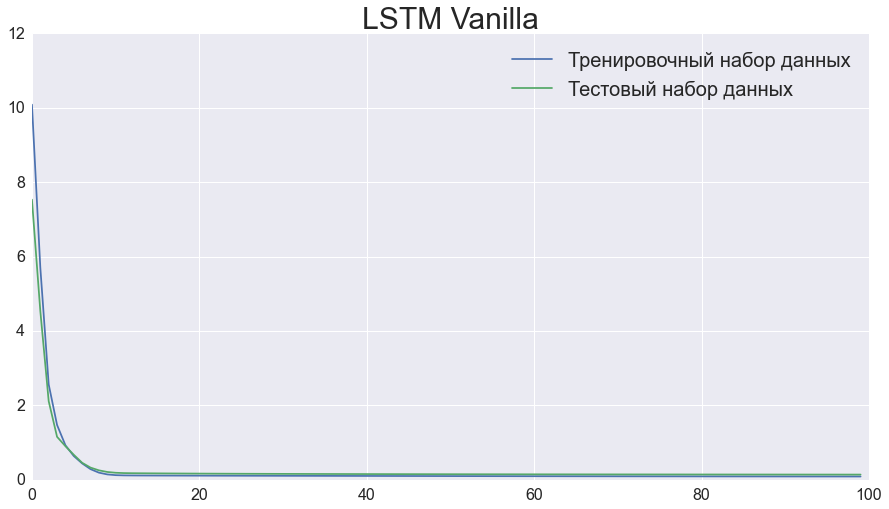

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.140
Test MAE: 0.272
Test RMSE: 0.374


evaluate the model
Train: 0.087, Test: 0.140


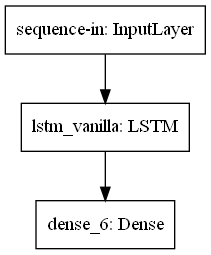

In [48]:
LSTM_Vanilla_model = build_LSTM_Vanilla_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_Vanilla_ATT = LSTM_Vanilla_model.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_Vanilla_ATT.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_Vanilla_ATT.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM Vanilla', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_Vanilla_model.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_Vanilla_model.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_Vanilla_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))


plot_model(LSTM_Vanilla_model, show_shapes=False, show_layer_names=True, to_file='LSTM_Vanilla_model.png')

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 6)]            0         
_________________________________________________________________
lstm_vanilla (LSTM)          (None, 1, 50)             11400     
_________________________________________________________________
attention (AttentionLayer)   (None, 50)                2600      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 14,051
Trainable params: 14,051
Non-trainable params: 0
_________________________________________________________________


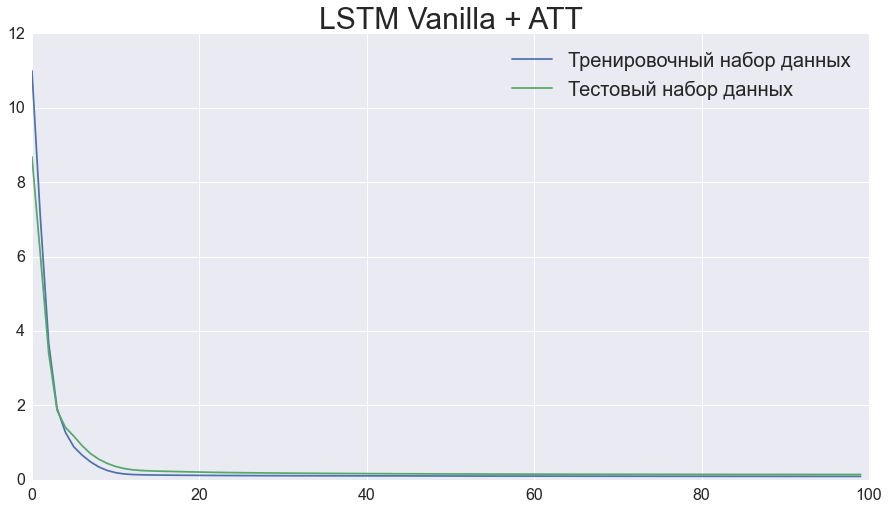

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test MSE: 0.143
Test MAE: 0.276
Test RMSE: 0.378


evaluate the model
Train: 0.089, Test: 0.143


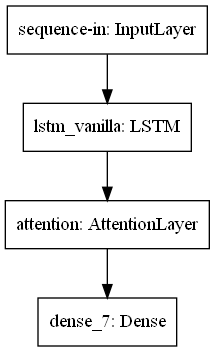

In [49]:
LSTM_Vanilla_ATT = build_LSTM_Vanilla_ATT_model()

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
# callbacks=[es] в fit добавить
history_Vanilla_ATT = LSTM_Vanilla_ATT.fit(train_X, train_y, epochs=epochs, validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_Vanilla_ATT.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_Vanilla_ATT.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM Vanilla + ATT', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_Vanilla_ATT.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
mse = mean_squared_error(test_y, pred_test_X)
mae = mean_absolute_error(test_y, pred_test_X)
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')

print('Test MSE: %.3f' % mse)
print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_Vanilla_ATT.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_Vanilla_ATT.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

plot_model(LSTM_Vanilla_ATT, show_shapes=False, show_layer_names=True, to_file='LSTM_Vanilla_ATT.png')

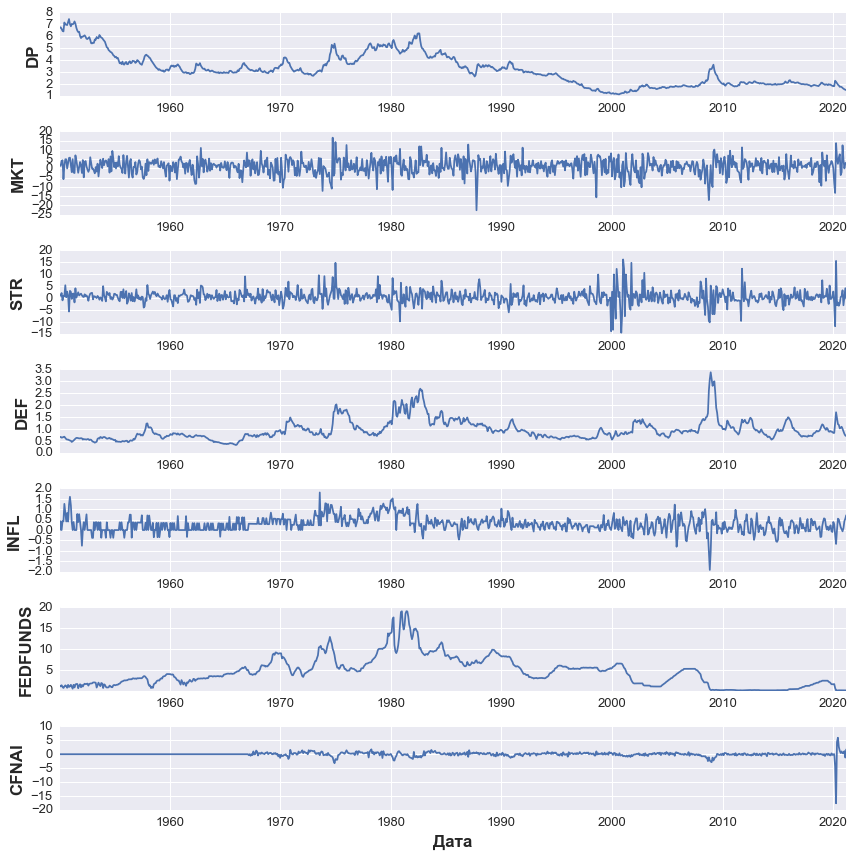

In [50]:
# Plot feature
fig = plt.figure(figsize=(12,12))


plt.subplot(711)
# plt.title('Финансовые признаки', fontsize = 20)
plt.ylabel('DP', fontweight='bold', fontsize=17)
plt.plot(df_all_f.Date, df_all_f.DP_t, label='DP')
plt.tick_params(axis='both', which='major', labelsize=13)
# plt.legend(loc='lower left')

plt.subplot(712)
plt.ylabel('MKT', fontweight='bold', fontsize=17)
plt.plot(df_all_f.Date, df_all_f.MKT_t, label='MKT')
plt.tick_params(axis='both', which='major', labelsize=13)
# plt.legend(loc='best')

plt.subplot(713)
plt.ylabel('STR', fontweight='bold', fontsize=17)
plt.plot(df_all_f.Date, df_all_f.STR_t, label='STR')
plt.tick_params(axis='both', which='major', labelsize=13)
# plt.legend(loc='lower left')

plt.subplot(714)
plt.ylabel('DEF', fontweight='bold', fontsize=17)
plt.plot(df_all_f.Date, df_all_f.DEF_t, label='DEF')
plt.tick_params(axis='both', which='major', labelsize=13)
# plt.legend(loc='lower left')

plt.subplot(715)
plt.ylabel('INFL', fontweight='bold', fontsize=17)
plt.plot(df_all_f.Date, df_all_f.infl_t, label='INFL')
plt.tick_params(axis='both', which='major', labelsize=13)
# plt.legend(loc='best')

plt.subplot(716)
plt.ylabel('FEDFUNDS', fontweight='bold', fontsize=17)
plt.plot(df_all_f.Date, df_all_f.fedfunds_t, label='FEDFUNDS')
plt.tick_params(axis='both', which='major', labelsize=13)
# plt.legend(loc='lower left')

plt.subplot(717)
plt.ylabel('CFNAI', fontweight='bold', fontsize=17)
plt.xlabel('Дата', fontweight='bold', fontsize=17)
plt.plot(df_all_f.Date, df_all_f.cfnai_t, label='CFNAI')
plt.tick_params(axis='both', which='major', labelsize=13)
# plt.legend(loc='best')

plt.tight_layout()

fig.savefig('finance_feature.jpg')


c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=-2.889795, expected=-3.048589
predicted=-2.979077, expected=-3.001937
predicted=-2.999930, expected=-3.427856
predicted=-3.111906, expected=-3.390439
predicted=-3.212548, expected=-3.214335
predicted=-3.211300, expected=-3.474797
predicted=-3.312286, expected=-3.083460
predicted=-3.204248, expected=-3.053130
predicted=-3.171950, expected=-2.337157
predicted=-2.727758, expected=-2.303948
predicted=-2.610988, expected=-2.632358
predicted=-2.688818, expected=-3.122878
predicted=-2.976487, expected=-2.858905
predicted=-2.820425, expected=-2.851549
predicted=-2.737063, expected=-2.830053
predicted=-2.754803, expected=-2.870183
predicted=-2.879987, expected=-2.952380
predicted=-2.927314, expected=-2.890497
predicted=-2.888029, expected=-3.014221
predicted=-2.944559, expected=-3.215394
predicted=-3.072598, expected=-2.951754
predicted=-2.991171, expected=-2.956337
predicted=-2.959025, expected=-2.661717
predicted=-2.799413, expected=-3.302249
predicted=-3.133312, expected=-3.384509


c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=-3.587049, expected=-3.155014
predicted=-3.393890, expected=-3.762064
predicted=-3.640319, expected=-3.872390
predicted=-3.749637, expected=-3.466360
predicted=-3.611287, expected=-3.670397
predicted=-3.565245, expected=-3.758578
predicted=-3.661104, expected=-3.716774
predicted=-3.755892, expected=-3.303438
predicted=-3.478197, expected=-3.082824
predicted=-3.280951, expected=-3.268201
predicted=-3.346172, expected=-3.837295
predicted=-3.673885, expected=-3.782527
predicted=-3.683427, expected=-3.852907
predicted=-3.676021, expected=-3.717078
predicted=-3.608143, expected=-3.968144
predicted=-3.837527, expected=-3.852594
predicted=-3.849406, expected=-3.258921
predicted=-3.541824, expected=-3.222778
predicted=-3.397615, expected=-3.725824
predicted=-3.647731, expected=-3.634668
predicted=-3.689948, expected=-3.260419
predicted=-3.408108, expected=-3.010703
predicted=-3.142334, expected=-2.635939
predicted=-2.950535, expected=-3.141315
predicted=-3.182883, expected=-3.193625


c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


predicted=-2.815389, expected=-2.902675
predicted=-3.130576, expected=-3.769055
predicted=-3.425487, expected=-3.403023
predicted=-3.321231, expected=-3.945042
predicted=-3.567904, expected=-3.151274
predicted=-3.166153, expected=-3.422477
predicted=-3.431203, expected=-3.714702
predicted=-3.556131, expected=-2.721638
predicted=-3.196739, expected=-3.704791
predicted=-3.476170, expected=-3.247721
predicted=-3.271752, expected=-4.045372
predicted=-3.841606, expected=-3.798084
predicted=-3.604139, expected=-3.397650
predicted=-3.533298, expected=-2.672009
predicted=-3.002597, expected=-1.307600
predicted=-2.192666, expected=-2.123484
predicted=-2.399477, expected=-2.752027
predicted=-2.761179, expected=-2.466245
predicted=-2.681330, expected=-3.216399
predicted=-2.722375, expected=-3.602143
predicted=-3.032870, expected=-2.658501
predicted=-2.840347, expected=-2.805091
predicted=-2.743181, expected=-2.997329
predicted=-2.871762, expected=-3.648049
predicted=-3.496468, expected=-3.088273


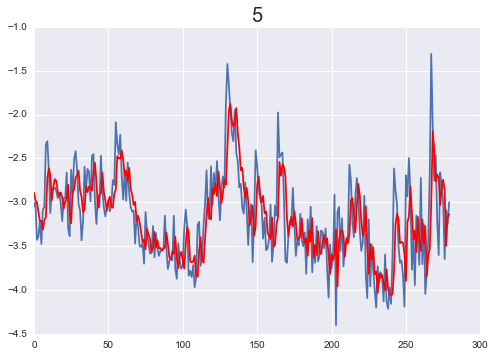

In [51]:
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
# fit an ARIMA model and plot residual errors
# from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.index = series.index.to_period('M')

X = df_all_f.RV_t.values


size = 574
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.title('5', fontsize=20)
pyplot.show()

c:\users\artemkoltsa\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


predicted=-2.843939, expected=-3.048589
predicted=-2.937159, expected=-3.001937
predicted=-2.917835, expected=-3.427856
predicted=-3.241288, expected=-3.390439
predicted=-3.308504, expected=-3.214335
predicted=-3.245798, expected=-3.474797
predicted=-3.407127, expected=-3.083460
predicted=-3.211205, expected=-3.053130
predicted=-3.126872, expected=-2.337157
predicted=-2.699240, expected=-2.303948
predicted=-2.484195, expected=-2.632358
predicted=-2.580971, expected=-3.122878
predicted=-2.836806, expected=-2.858905
predicted=-2.811633, expected=-2.851549
predicted=-2.852661, expected=-2.830053
predicted=-2.871205, expected=-2.870183
predicted=-2.856156, expected=-2.952380
predicted=-2.907792, expected=-2.890497
predicted=-2.889768, expected=-3.014221
predicted=-2.963121, expected=-3.215394
predicted=-3.106035, expected=-2.951754
predicted=-2.999079, expected=-2.956337
predicted=-2.989050, expected=-2.661717
predicted=-2.816551, expected=-3.302249
predicted=-3.094068, expected=-3.384509


predicted=-3.228297, expected=-3.557056
predicted=-3.476144, expected=-3.182607
predicted=-3.228687, expected=-3.731141
predicted=-3.538205, expected=-3.513832
predicted=-3.513099, expected=-3.428454
predicted=-3.465594, expected=-3.379762
predicted=-3.438605, expected=-2.570918
predicted=-2.931043, expected=-2.754088
predicted=-2.862054, expected=-3.213001
predicted=-3.044978, expected=-3.397768
predicted=-3.196431, expected=-2.932243
predicted=-3.043025, expected=-2.724417
predicted=-2.901519, expected=-2.975825
predicted=-2.959380, expected=-3.332735
predicted=-3.141242, expected=-3.554472
predicted=-3.353186, expected=-3.456095
predicted=-3.411229, expected=-2.927694
predicted=-3.149741, expected=-3.823303
predicted=-3.577260, expected=-4.091856
predicted=-3.817227, expected=-3.196535
predicted=-3.423330, expected=-3.959107
predicted=-3.825757, expected=-3.481436
predicted=-3.584720, expected=-3.776988
predicted=-3.693153, expected=-3.999835
predicted=-3.876666, expected=-4.202129


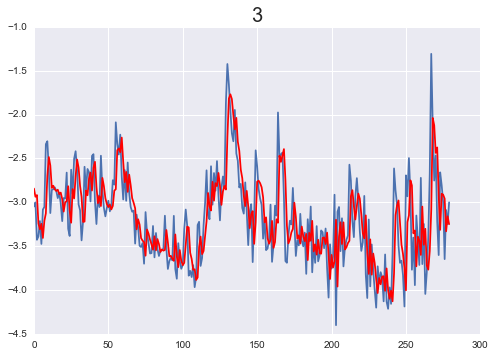

In [52]:
from datetime import datetime
# fit an ARIMA model and plot residual errors
# from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.index = series.index.to_period('M')

X = df_all_f.RV_t.values


size = 574
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(3,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)
print('Test MSE: %.3f' % mse)

# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.title('3', fontsize=20)
pyplot.show()

In [54]:
# преобразование в массив (array)
values = X_RV_all.values
# split into train and test sets
train = values[:700, :]
test = values[700:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# # reshape input to be 3D [samples, timesteps, features]
# samples_train_X = train_X.shape[0]
# samples_test_X = test_X.shape[0]
# timesteps = 1
# features_train_X = train_X.shape[1]
# features_test_X = test_X.shape[1]

# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

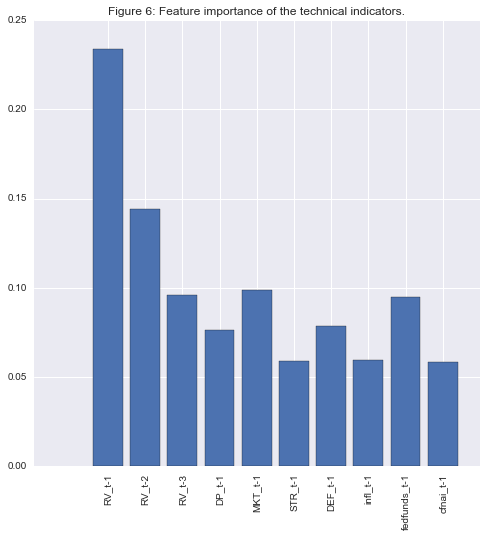

In [55]:
from xgboost import XGBRegressor

regressor = XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(train_X,train_y, eval_set = [(train_X, train_y), (test_X, test_y)], verbose=False)
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_RV_all.iloc[:, :-1].columns)
feature_importances = [0.22610463201999664, 0.1430523842573166, 0.09799089282751083, 0.08177240937948227, 0.10480271279811859, 0.0571393184363842, 0.10775644332170486, 0.06042138859629631, 0.1021876186132431, 0.0557495579123497]
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

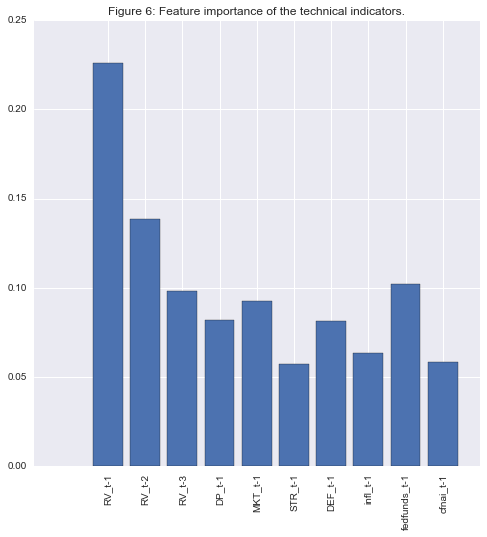

In [56]:
from xgboost import XGBRegressor

regressor = XGBRegressor(gamma=0.0,n_estimators=200,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(train_X,train_y, verbose=False)
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_RV_all.iloc[:, :-1].columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

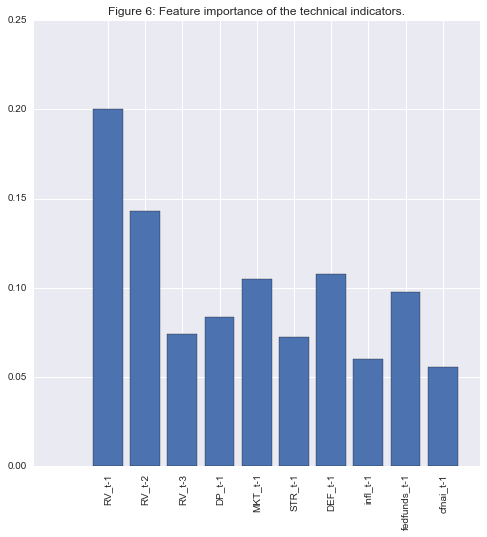

In [57]:
from xgboost import XGBRegressor

regressor = XGBRegressor()
xgbModel = regressor.fit(train_X,train_y, verbose=False)
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_RV_all.iloc[:, :-1].columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

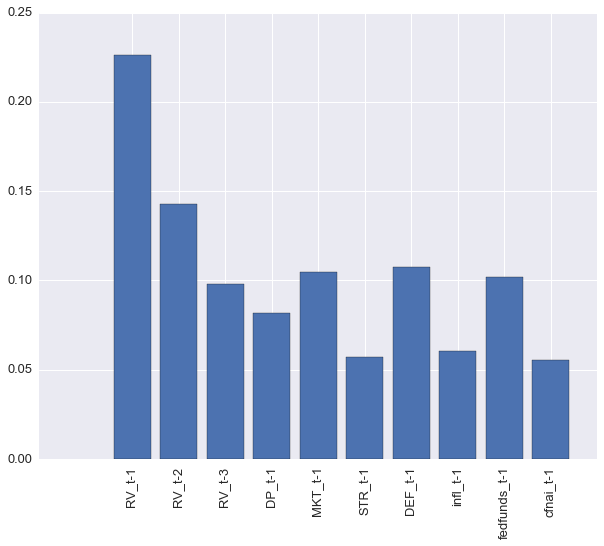

<Figure size 576x396 with 0 Axes>

In [58]:
fig = plt.figure(figsize=(10,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], feature_importances, tick_label=X_RV_all.iloc[:, :-1].columns)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

plt.tight_layout()

fig.savefig('xgb_feature_importances.jpg')

In [59]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

#         waste = 32
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            print(start, mid, stop)
            yield indices[start: mid], indices[mid + margin: stop]

In [60]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
                   vmin=-.2, vmax=1.2)

    # Formatting
    ax.set(yticks=np.arange(n_splits),
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits, -.2]) #, xlim=[0, 100])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=17)
    return ax

In [65]:
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.model_selection import cross_val_score
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV

# def build_LSTM_model():
#     model_in = Input(shape=(X.shape[1], X.shape[2]), name='sequence-in')
#     vectors  = LSTM(units=units_lstm, name='lstm')(model_in)
#     output   = Dense(units=1)(vectors)

#     # (b, t, d)
#     model = models.Model(inputs=[model_in], outputs=[output])
#     model.summary()
#     model.compile(loss='mse', optimizer='adam')
#     return model

# # X = X_a.iloc[:, :7]
# # y = X_a.iloc[:, 7]

# # create model
# model = KerasRegressor(build_fn=build_LSTM_model, epochs=100, verbose=0)

# tscv = BlockingTimeSeriesSplit(n_splits=7)

# results = cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_squared_error')
# print(results.mean())
# print(results)
# print("Loss: {0:.3f} (+/- {1:.3f})".format(results.mean(), results.std()))

# BlockingTimeSeriesSplit - CROSS VALIDATION - sklearn

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor

def build_LSTM_model():
    model_in = Input(shape=(X_train.shape[1], X_train.shape[2]), name='sequence-in')
    vectors  = LSTM(units=50, name='lstm')(model_in)
    output   = Dense(units=1)(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
#     model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

X = X_RV_art_a.iloc[:, :7]
y = X_RV_art_a.iloc[:, 7:]

btscv = BlockingTimeSeriesSplit(n_splits=5)
rmse = []
mae = []
mse = []
i=0
for train_index, test_index in btscv.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("------------------SPLIT %s----------------" % (i+1))
    print("Train Start: %d -> End %d" % (train_index[0], train_index[-1]))
    print("Test Start: %d -> End %d" % (test_index[0], test_index[-1]))
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print("#" * 50)
    X_train = X_train.values
    X_test = X_test.values
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    LSTM_model = build_LSTM_model()
    LSTM_model.fit(X_train, y_train, epochs=100, verbose=0, shuffle=False)
    
    pred_test_X = LSTM_model.predict(X_test)

    rmse.append(sqrt(mean_squared_error(y_test, pred_test_X)))
#     mse.append(mean_squared_error(y_test, pred_test_X)
#     mae.append(mean_absolute_error(y_test, pred_test_X)
#         print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')
    print('Test RMSE: %.3f' % rmse[i])
#     print('Test MSE: %.3f' % mse[i])
#     print('Test MAE: %.3f' % mae[i])
    i += 1
    print('\n')
    
print("RMSE: {}".format(rmse))
print('\n')
print("Mean RMSE: {}".format(np.mean(rmse)))
print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_model.evaluate(X_train, y_train, verbose=1)
test_mse = LSTM_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

0 136 170
------------------SPLIT 1----------------
Train Start: 0 -> End 135
Test Start: 136 -> End 169
(136, 7) (136, 1)
(34, 7) (34, 1)
##################################################
(136, 1, 7) (136, 1) (34, 1, 7) (34, 1)
Test RMSE: 0.489


170 306 340
------------------SPLIT 2----------------
Train Start: 170 -> End 305
Test Start: 306 -> End 339
(136, 7) (136, 1)
(34, 7) (34, 1)
##################################################
(136, 1, 7) (136, 1) (34, 1, 7) (34, 1)
Test RMSE: 0.234


340 476 510
------------------SPLIT 3----------------
Train Start: 340 -> End 475
Test Start: 476 -> End 509
(136, 7) (136, 1)
(34, 7) (34, 1)
##################################################
(136, 1, 7) (136, 1) (34, 1, 7) (34, 1)
Test RMSE: 0.354


510 646 680
------------------SPLIT 4----------------
Train Start: 510 -> End 645
Test Start: 646 -> End 679
(136, 7) (136, 1)
(34, 7) (34, 1)
##################################################
(136, 1, 7) (136, 1) (34, 1, 7) (34, 1)
Test RMSE: 

0 136 170
170 306 340
340 476 510
510 646 680
680 816 850


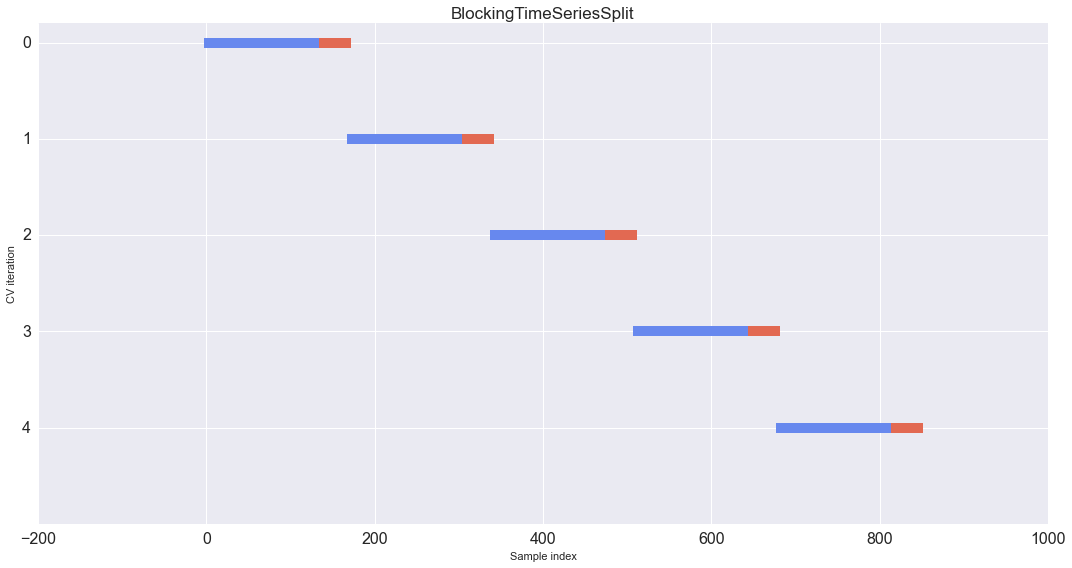

In [66]:
fig, ax = plt.subplots(figsize=(15,8))


# plt.tick_params(axis='both', which='major', labelsize=13)
# # plt.ylabel(fontweight='bold', fontsize=17)
# plt.xlabel(fontweight='bold', fontsize=17)
plot_cv_indices(btscv, X, y, ax, 5)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.tight_layout()
pyplot.show()
fig.savefig('blockingTimeSeriseSplit.jpg')

In [67]:
# TIMESERIES SPLIT - CROSS VALIDATION - sklearn

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor

def build_LSTM_model():
    model_in = Input(shape=(X_train.shape[1], X_train.shape[2]), name='sequence-in')
    vectors  = LSTM(units=50, name='lstm')(model_in)
    output   = Dense(units=1)(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
#     model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

X = X_RV_art_a.iloc[:, :7]
y = X_RV_art_a.iloc[:, 7:]

tscv = TimeSeriesSplit(n_splits=5)
i=0
rmse = []


cvscores = []

for train_index, test_index in tscv.split(X, y):
#    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print("------------------SPLIT %s----------------" % (i+1))
    print("Train Start: %d -> End %d" % (train_index[0], train_index[-1]))
    print("Test Start: %d -> End %d" % (test_index[0], test_index[-1]))
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print("#" * 50)
    X_train = X_train.values
    X_test = X_test.values
    
    # reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    LSTM_model = build_LSTM_model()
    LSTM_model.fit(X_train, y_train, epochs=100, verbose=0, shuffle=False)
    
    pred_test_X = LSTM_model.predict(X_test)
                
    rmse.append(sqrt(mean_squared_error(y_test, pred_test_X)))
    print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')
    print('Test RMSE: %.3f' % rmse[i])
    i += 1
    print('\n')
    
print("RMSE: {}".format(rmse))
print('\n')
print("Mean RMSE: {}".format(np.mean(rmse)))
print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_model.evaluate(X_train, y_train, verbose=1)
test_mse = LSTM_model.evaluate(X_test, y_test, verbose=1)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# # evaluate the model
# scores = LSTM_model.evaluate(X_test, y_test, verbose=0)
# print("%s: %.2f%%" % (LSTM_model.metrics_names[1], scores[1]*100))
# cvscores.append(scores[1] * 100)
# print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

------------------SPLIT 1----------------
Train Start: 0 -> End 143
Test Start: 144 -> End 285
(144, 7) (144, 1)
(142, 7) (142, 1)
##################################################
(144, 1, 7) (144, 1) (142, 1, 7) (142, 1)
Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test RMSE: 0.374


------------------SPLIT 2----------------
Train Start: 0 -> End 285
Test Start: 286 -> End 427
(286, 7) (286, 1)
(142, 7) (142, 1)
##################################################
(286, 1, 7) (286, 1) (142, 1, 7) (142, 1)
Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test RMSE: 0.324


------------------SPLIT 3----------------
Train Start: 0 -> End 427
Test Start: 428 -> End 569
(428, 7) (428, 1)
(142, 7) (142, 1)
##################################################
(428, 1, 7) (428, 1) (142, 1, 7) (142, 1)
Среднеквадратичная ошибка ра

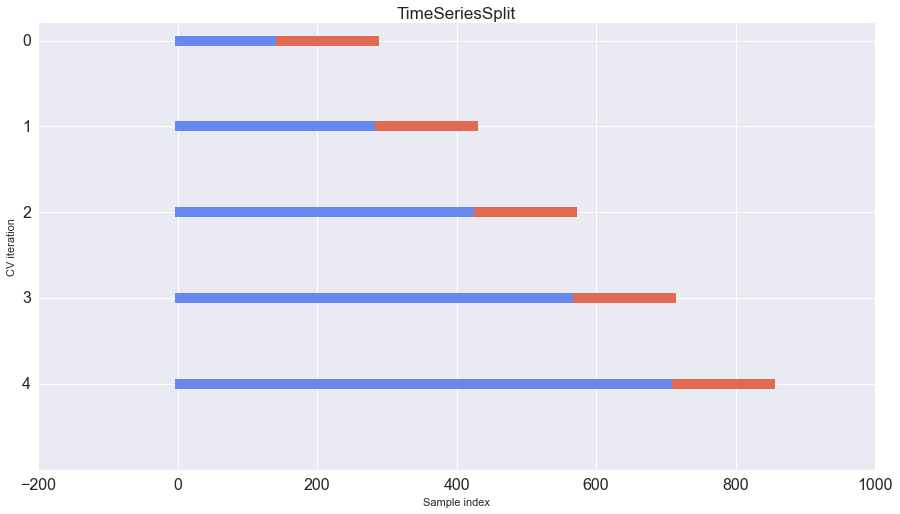

In [68]:
fig, ax = plt.subplots(figsize=(15,8))

plot_cv_indices(tscv, X, y, ax, 5)
pyplot.tick_params(axis='both', which='major', labelsize=16)
fig.savefig('TimeSeriseSplit.jpg')

In [74]:
df_all_f_upd_RV = pd.read_csv('df_all_features_update_RV.csv')

# from February 1950 to December 2017 for a total of 815 observations
X_a = df_all_f_upd_RV[['RV_t-1', 'RV_t-2', 'RV_t-3', 'DP_t-1', 'MKT_t-1', 'STR_t-1', 'DEF_t-1', 'RV_t']]
print(X_a)

# преобразование в массив (array)
values = X_a.values
# split into train and test sets
train = values[:600, :]
test = values[600:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
samples_train_X = train_X.shape[0]
samples_test_X = test_X.shape[0]
timesteps = 1
features_train_X = train_X.shape[1]
features_test_X = test_X.shape[1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

       RV_t-1    RV_t-2    RV_t-3  DP_t-1  MKT_t-1  STR_t-1  DEF_t-1      RV_t
0   -3.453332 -3.826444 -3.517811    6.81     1.79     0.76     0.67 -3.867846
1   -3.867846 -3.453332 -3.826444    6.74     1.57     1.10     0.66 -3.806101
2   -3.806101 -3.867846 -3.453332    6.74     1.36     0.96     0.66 -3.615267
3   -3.615267 -3.806101 -3.867846    6.61     4.03     2.08     0.63 -3.616941
4   -3.616941 -3.615267 -3.806101    6.45     4.41    -1.00     0.64 -2.581866
..        ...       ...       ...     ...      ...      ...      ...       ...
810 -4.129643 -3.855847 -3.797363    1.94     1.94     2.02     0.69 -3.595473
811 -3.595473 -4.129643 -3.855847    1.95     0.25    -0.45     0.68 -4.132735
812 -4.132735 -3.595473 -4.129643    1.93     2.60     2.76     0.67 -4.215156
813 -4.215156 -4.132735 -3.595473    1.89     2.34    -0.73     0.72 -3.971224
814 -3.971224 -4.215156 -4.132735    1.88     3.20     0.34     0.70 -4.158940

[815 rows x 8 columns]
(600, 1, 7) (600,) (215, 1, 

In [75]:
# hyperparameters
# ПАРАМЕТРЫ ПРИ КОТОРЫХ ДАЮТ LOSS TEST, USUAL LSTM = 0.051, LSTM VANILLA ATT = 0.004.
#patience = 20
#epochs = 100
#units_lstm = 50

In [76]:
# hyperparameters

patience = 20
epochs = 100
units_lstm = 50

In [77]:
def build_LSTM_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, name='lstm')(model_in)
    output   = Dense(units=1)(vectors)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_ATT_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, name='lstm', return_sequences=True)(model_in)
    descr    = AttentionLayer(name='attention')(vectors)
    output   = Dense(units=1)(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model

def build_LSTM_Vanilla_ATT_model():
    model_in = Input(shape=(train_X.shape[1], train_X.shape[2]), name='sequence-in')
    vectors  = LSTM(units=units_lstm, activation='relu', name='lstm_vanilla', return_sequences=True)(model_in)
    descr    = AttentionLayer(name='attention')(vectors)
    output   = Dense(units=1)(descr)

    # (b, t, d)
    model = models.Model(inputs=[model_in], outputs=[output])
    model.summary()
    model.compile(loss='mse', optimizer='adam')
    return model


In [78]:
# EarlyStopping & ModelCheckpoint callback

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
# mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

# model.fit(..., callbacks=[es, mc])

# load a saved model
# from keras.models import load_model
# saved_model = load_model('best_model.h5')

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                11600     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________
Epoch 00089: early stopping


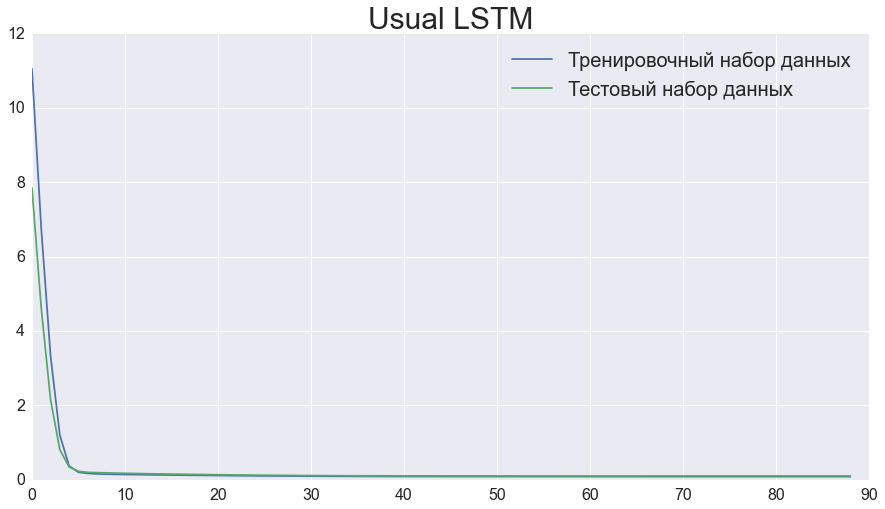

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test RMSE: 0.321


evaluate the model
Train: 0.083, Test: 0.103


In [79]:
LSTM_model = build_LSTM_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
history_LSTM = LSTM_model.fit(train_X, train_y, epochs=epochs, callbacks=[es], validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('Usual LSTM', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_model.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')
print('Test RMSE: %.3f' % rmse)
print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_model.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_model.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

In [80]:
len(history_LSTM.history['loss'])

89

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 7)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 50)             11600     
_________________________________________________________________
attention (AttentionLayer)   (None, 50)                2600      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________
Epoch 00078: early stopping


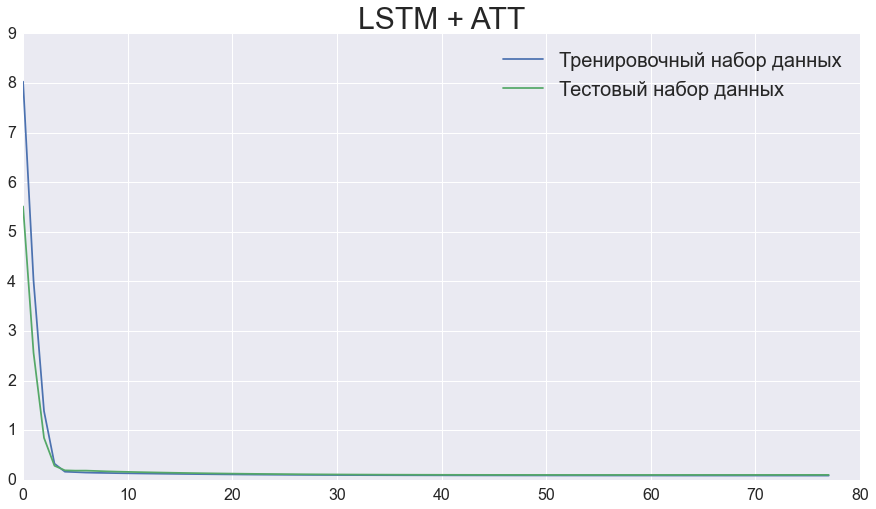

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test RMSE: 0.315


evaluate the model
Train: 0.084, Test: 0.099


In [81]:
LSTM_ATT = build_LSTM_ATT_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
history_LSTM_ATT = LSTM_ATT.fit(train_X, train_y, epochs=epochs, callbacks=[es], validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_LSTM_ATT.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_LSTM_ATT.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM + ATT', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_ATT.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')
print('Test RMSE: %.3f' % rmse)
print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_ATT.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_ATT.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence-in (InputLayer)     [(None, 1, 7)]            0         
_________________________________________________________________
lstm_vanilla (LSTM)          (None, 1, 50)             11600     
_________________________________________________________________
attention (AttentionLayer)   (None, 50)                2600      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 14,251
Trainable params: 14,251
Non-trainable params: 0
_________________________________________________________________


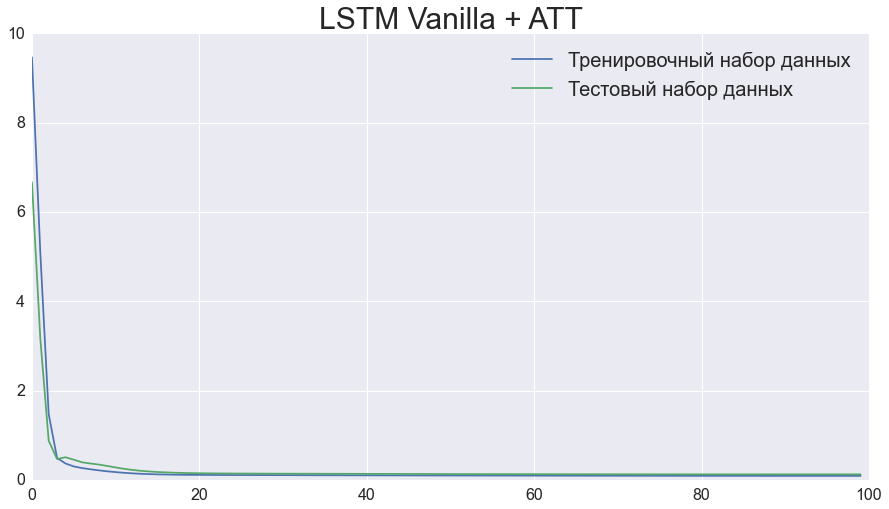

Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.
Test RMSE: 0.350


evaluate the model
Train: 0.085, Test: 0.123


In [82]:
LSTM_Vanilla_ATT = build_LSTM_Vanilla_ATT_model()

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
history_Vanilla_ATT = LSTM_Vanilla_ATT.fit(train_X, train_y, epochs=epochs, callbacks=[es], validation_data=(test_X, test_y), verbose=0, shuffle=False)
# plot history
pyplot.figure(figsize=(15,8))
pyplot.plot(history_Vanilla_ATT.history['loss'], label='Тренировочный набор данных')
pyplot.plot(history_Vanilla_ATT.history['val_loss'], label='Тестовый набор данных')
pyplot.legend(fontsize=20)
pyplot.tick_params(axis='both', which='major', labelsize=16)
pyplot.title('LSTM Vanilla + ATT', size=30)
pyplot.show()

# calculate RMSE
# pred_test_X - предсказания по тестовому набору
pred_test_X = LSTM_Vanilla_ATT.predict(test_X)
# test_y - реальные ответы по тестовому набору
rmse = sqrt(mean_squared_error(test_y, pred_test_X))
print('Среднеквадратичная ошибка рассчитывается как среднее значение квадратов разностей между прогнозируемыми и фактическими значениями.')
print('Test RMSE: %.3f' % rmse)
print('\n')

# evaluate the model
print('evaluate the model')
train_mse = LSTM_Vanilla_ATT.evaluate(train_X, train_y, verbose=0)
test_mse = LSTM_Vanilla_ATT.evaluate(test_X, test_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

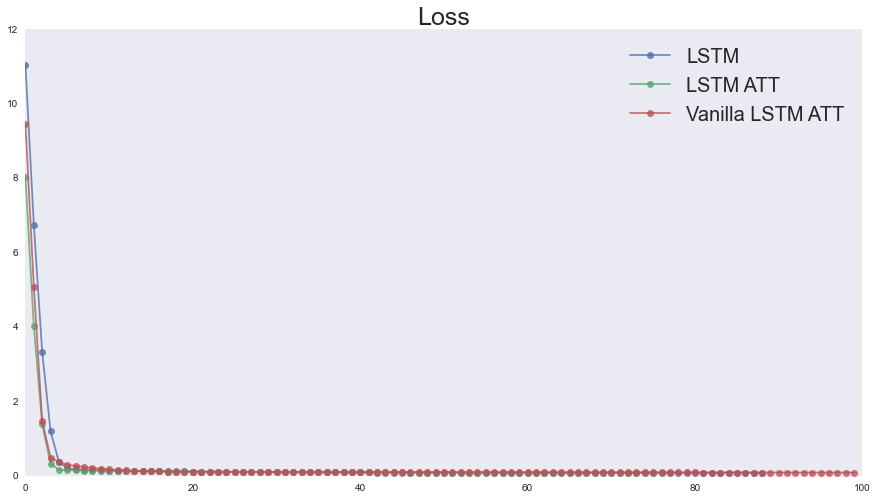

In [83]:
plt.figure(figsize=(15,8))
plt.title("Loss", fontsize=25) 
plt.plot(history_LSTM.history['loss'], 'o-', alpha=0.8, label='LSTM')
plt.plot(history_LSTM_ATT.history['loss'], 'o-', alpha=0.8, label='LSTM ATT')
plt.plot(history_Vanilla_ATT.history['loss'], 'o-', alpha=0.8, label='Vanilla LSTM ATT')
plt.grid(alpha=0.4)

plt.legend(fontsize=20)

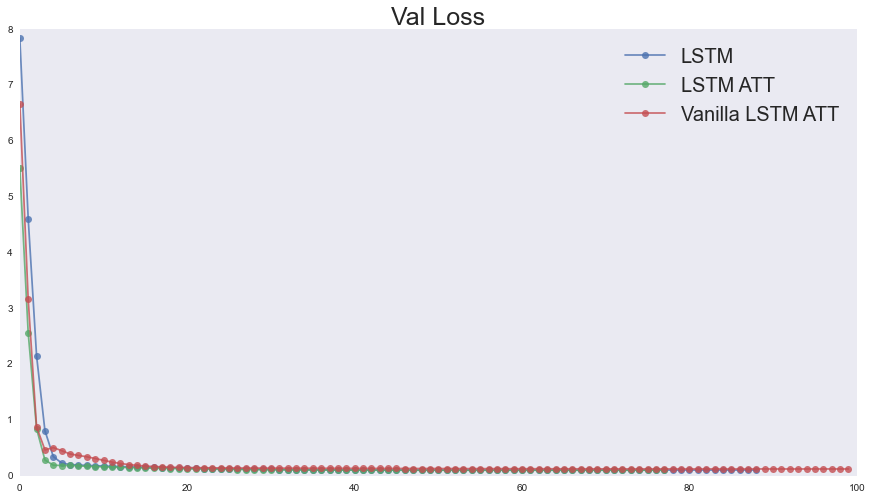

In [84]:
plt.figure(figsize=(15,8))
plt.title("Val Loss", fontsize=25) 
plt.plot(history_LSTM.history['val_loss'], 'o-', alpha=0.8, label='LSTM')
plt.plot(history_LSTM_ATT.history['val_loss'], 'o-', alpha=0.8, label='LSTM ATT')
plt.plot(history_Vanilla_ATT.history['val_loss'], 'o-', alpha=0.8, label='Vanilla LSTM ATT')
plt.grid(alpha=0.4)

plt.legend(fontsize=20)